In [1]:
from mendeleev import element
#import pymatgen.core as mg
import matplotlib.pyplot as plt
#import matplotlib as mpl
#from mpl_toolkits.mplot3d import Axes3D
import numpy as np
#import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#import quadpy
from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations
from joblib import Parallel, delayed, parallel_backend
from scipy import integrate
import time
from datetime import timedelta
import plotly as plotly
import plotly.express as px
#from plotly.offline import init_notebook_mode
#init_notebook_mode(connected=True)  
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.graph_objects as go
import latex
import os
from plotly.subplots import make_subplots

def crystal(i):
    switcher={
        45: "Li", 
        44: "Cu",
        43: "Mn",
        42: "Al",            
        41: "Au",            
        40: "Ca",      
        39: "Cr",        
        38: "Fe",            
        37: "Ge",            
        36: "Ir",      
        35: "Pd",        
        34: "Pt",            
        33: "Ru",            
        32: "Si",      
        31: "Tc",
        30: "Ti",
        29: "V",
        28: "W",
        27: "Mg",
        26: "Co",
        25: "Sc", 
        24: "Hg",
        23: "Mo", 
        22: "Os",
        21: "Rh",
        20: "Ag",
        19: "Cd",
        18: "Hf",
        17: "K",
        16: "Na",
        15: "Nb",
        14: "Ni",
        13: "Re",
        12: "Sb",
        11: "Sr",
        10: "Ta",
        9: "Y",
        8: "Zr",
        7: "Ba",
        6: "Cs",
        5: "In",
        4: "Rb",
        3: "Sn",
        2: "Pb",
        1: "Tl",
    }
    return switcher.get(i,"Invalid crystal")

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)  
import plotly.io as pio
pio.renderers.default = 'iframe'

df_OCTA=pd.read_csv("OCTA_DATASET.csv")
df_TETRA=pd.read_csv("TETRA_DATASET.csv")

# df_OCTA_BE=pd.read_csv("/home/massad/Documents/Linux_PHD/SUPERCELLS/BE/Binding_Energies_OI.csv")
# df_TETRA_BE=pd.read_csv("/home/massad/Documents/Linux_PHD/SUPERCELLS/BE/Binding_Energies_TI.csv")

# df_OCTA_SE=pd.read_csv("/home/massad/Documents/Linux_PHD/SUPERCELLS/BE/SolutionE_OI.csv")
# df_TETRA_SE=pd.read_csv("/home/massad/Documents/Linux_PHD/SUPERCELLS/BE/SolutionE_TI.csv")

frames = [df_OCTA, df_TETRA]

result = pd.concat(frames, keys=["OCTA", "TETRA"])
result =result.drop(columns = 'Name',axis=1)

# df_OCTA["VALENCE"]

In [2]:
def confidence_ellipse(x, y, n_std=1.96, size=100):
    """
    Get the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    size : int
        Number of points defining the ellipse
    Returns
    -------
    String containing an SVG path for the ellipse
    
    References (H/T)
    ----------------
    https://matplotlib.org/3.1.1/gallery/statistics/confidence_ellipse.html
    https://community.plotly.com/t/arc-shape-with-path/7205/5
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    theta = np.linspace(0, 2 * np.pi, size)
    ellipse_coords = np.column_stack([ell_radius_x * np.cos(theta), ell_radius_y * np.sin(theta)])
    
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    x_scale = np.sqrt(cov[0, 0]) * n_std
    x_mean = np.mean(x)

    # calculating the stdandard deviation of y ...
    y_scale = np.sqrt(cov[1, 1]) * n_std
    y_mean = np.mean(y)
  
    translation_matrix = np.tile([x_mean, y_mean], (ellipse_coords.shape[0], 1))
    rotation_matrix = np.array([[np.cos(np.pi / 4), np.sin(np.pi / 4)],
                                [-np.sin(np.pi / 4), np.cos(np.pi / 4)]])
    scale_matrix = np.array([[x_scale, 0],
                            [0, y_scale]])
    ellipse_coords = ellipse_coords.dot(rotation_matrix).dot(scale_matrix) + translation_matrix
        
    path = f'M {ellipse_coords[0, 0]}, {ellipse_coords[0, 1]}'
    for k in range(1, len(ellipse_coords)):
        path += f'L{ellipse_coords[k, 0]}, {ellipse_coords[k, 1]}'
    path += ' Z'
    return path

In [3]:
# give to NaN some number which is always the same 
X_mdf=result

X_mdf['Ch(H) exchange']=X_mdf['Ch(H)']-1.00
X_mdf['Ch(M) exchange']=X_mdf['VALENCE']-X_mdf['Ch(M)']
del X_mdf['Ch(H)']
del X_mdf['Ch(M)']

X_mdf=result.dropna(axis='columns')

#print("DISREGARDING\n",X_mdf.iloc[:, 6:27])
#X_mdf=X_mdf.drop(X_mdf.iloc[:, 4:5], axis = 1)
#X_mdf=X_mdf.drop(X_mdf.iloc[:, 6:27], axis = 1)

# del X_mdf["density"]
# del X_mdf["fusion_heat"]
# del X_mdf["glawe_number"]
# del X_mdf["mendeleev_number"]
# del X_mdf["boiling_point"]

# del X_mdf['covalent_radius_cordero']
# del X_mdf['covalent_radius_pyykko']
# del X_mdf['metallic_radius']
# del X_mdf['vdw_radius'] 
# del X_mdf['vdw_radius_alvarez']
# del X_mdf['vdw_radius_batsanov']
# del X_mdf['vdw_radius_uff']


X_mdf.isna().sum()

# TOREMOVE
# density                          0
# fusion_heat                      0
# glawe_number                     0
# mendeleev_number                 0
X_mdf

Atomic Number  Atomic Radius  Atomic Volume  atomic_weight  \
OCTA  0              81          190.0          17.20     204.380000   
      1              82          180.0          18.30     207.200000   
      2              50          145.0          16.30     118.710000   
      3              37          235.0          55.90      85.467800   
      4              49          155.0          15.70     114.818000   
...                 ...            ...            ...            ...   
TETRA 30             79          135.0          10.20     196.966569   
      31             13          125.0          10.00      26.981538   
      32             25          140.0           7.39      54.938044   
      33             29          135.0           7.10      63.546000   
      34              3          145.0          13.10       6.940000   

          dipole_polarizability  period  boiling_point  \
OCTA  0                 50.0000       6        1730.00   
      1                 47.0000       6        2013.00   
      2                 53.0000       5        2543.00   
      3                319.8000       5         961.00   
      4                 65.0000       5        2353.00   
...                         ...     ...            ...   
TETRA 30                36.0000       6        3080.00   
      31                57.8000       3        2740.00   
      32                68.0000       4        2235.00   
      33                46.5000       4        2840.00   
      34               164.1125       2        1118.15   

          covalent_radius_cordero  covalent_radius_pyykko  \
OCTA  0                     145.0                   144.0   
      1                     146.0                   144.0   
      2                     139.0                   140.0   
      3                     220.0                   210.0   
      4                     142.0                   142.0   
...                           ...                     ...   
TETRA 30                    136.0                   124.0   
      31                    121.0                   126.0   
      32                    150.0                   119.0   
      33                    132.0                   112.0   
      34                    128.0                   133.0   

          covalent_radius_pyykko_double  ...         V_H       Lat  \
OCTA  0                           142.0  ...   52.687930  5.002120   
      1                           135.0  ...   50.747294  5.069333   
      2                           130.0  ...   47.363754  4.872865   
      3                           202.0  ...  172.325983  6.896321   
      4                           136.0  ...   59.032840  4.824002   
...                                 ...  ...         ...       ...   
TETRA 30                          121.0  ...   23.280690  4.207946   
      31                          113.0  ...   80.546765  4.051156   
      32                          105.0  ...   21.893630  3.524944   
      33                          115.0  ...   23.330764  3.644979   
      34                          124.0  ...  129.875995  4.288954   

               BULKM      YOUNGM      SHEARM  POISSONR  peak_width   MAX_rdf  \
OCTA  0    296.44047    41.28377    14.68947   0.40522    5.123690  0.043096   
      1    407.73666  -233.36752   -65.40753   0.78395    3.311369  0.000320   
      2    439.46883   216.13070    76.94449   0.40446    5.076671  0.042318   
      3     33.59768    26.82293     9.93748   0.34958    2.308308  0.000124   
      4    343.24574    95.77966    33.29902   0.43818    5.124412  0.044712   
...              ...         ...         ...       ...         ...       ...   
TETRA 30  1246.19358   181.33488    66.85944   0.35609    5.042500  0.041849   
      31   753.26295  6628.79311 -2318.56397  -2.42950    5.118417  0.091678   
      32  2610.34410  3979.29705  1597.40238   0.24555    5.599272  0.107534   
      33  1713.15436  1364.14460   499.08408   0.36665    5.554652  0.0828

In [4]:
scaler = StandardScaler()

scaler.fit(X_mdf)

standardized_data = scaler.transform(X_mdf)
#standardized_data = standardized_data.T
X_mdf_std = standardized_data

print(X_mdf_std.mean())
print(X_mdf_std.std())

print("Column 1 mean,",X_mdf_std[:,0].mean())
print("Column 2 mean,",X_mdf_std[:,1].mean())
print("Column 1 var,",X_mdf_std[:,1].var())
print("Row 1 mean,",X_mdf_std[0,:].mean())
print("Row 1 var,",X_mdf_std[0,:].var())

7.566537408246712e-17
1.0
Column 1 mean, 7.930164461608261e-17
Column 2 mean, -4.496403249731884e-16
Column 1 var, 0.9999999999999996
Row 1 mean, 0.20285938063353717
Row 1 var, 0.8048979080534348


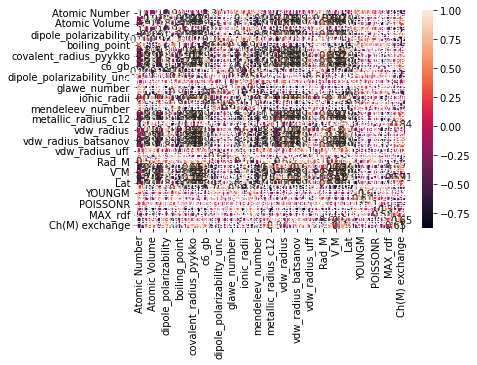

In [5]:
import seaborn as sn
corrMatrix = X_mdf.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [6]:
features = X_mdf.keys() 
print(features[33])

X_f=[]
for i in range (0,len(features)):
    X_f.append(features[i])
print(X_f)

index=X_f.index('BULKM')
X_f[index]='Bulk Modulus'
index=X_f.index('YOUNGM')
X_f[index]='Young Modulus'
index=X_f.index('SHEARM')
X_f[index]='Shear Modulus'
index=X_f.index('POISSONR')
X_f[index]='Poisson Ratio'
index=X_f.index('Lat')
X_f[index]='Lattice const.'

index=X_f.index('Rad_H')
X_f[index]='Radius H Ch.'
index=X_f.index('V_M')
X_f[index]='Volume M Ch.'
index=X_f.index('V_H')
X_f[index]='Volume H Ch.'
index=X_f.index('Rad_M')
X_f[index]='Radius M Ch.'

print(X_f)

BULKM
['Atomic Number', 'Atomic Radius', 'Atomic Volume', 'atomic_weight', 'dipole_polarizability', 'period', 'boiling_point', 'covalent_radius_cordero', 'covalent_radius_pyykko', 'covalent_radius_pyykko_double', 'c6_gb', 'density', 'dipole_polarizability_unc', 'fusion_heat', 'glawe_number', 'heat_of_formation', 'ionic_radii', 'melting_point', 'mendeleev_number', 'metallic_radius', 'metallic_radius_c12', 'specific_heat', 'vdw_radius', 'vdw_radius_alvarez', 'vdw_radius_batsanov', 'vdw_radius_mm3', 'vdw_radius_uff', 'VALENCE', 'Rad_M', 'Rad_H', 'V_M', 'V_H', 'Lat', 'BULKM', 'YOUNGM', 'SHEARM', 'POISSONR', 'peak_width', 'MAX_rdf', 'Ch(H) exchange', 'Ch(M) exchange']
['Atomic Number', 'Atomic Radius', 'Atomic Volume', 'atomic_weight', 'dipole_polarizability', 'period', 'boiling_point', 'covalent_radius_cordero', 'covalent_radius_pyykko', 'covalent_radius_pyykko_double', 'c6_gb', 'density', 'dipole_polarizability_unc', 'fusion_heat', 'glawe_number', 'heat_of_formation', 'ionic_radii', 'melt

In [7]:
pio.renderers.default = "notebook_connected"
fig = px.imshow(corrMatrix, x=X_f,y=X_f, text_auto=".1f")
fig.update_layout(coloraxis_colorbar_x=0.72)
fig.show()
# fig['layout'].update(xaxis=dict(tickfont = dict(size=34)),yaxis=dict(tickfont = dict(size=34)))
# plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/CorrelationMatrix.html')

In [8]:
# corrMatrix_submat_peaks = X_mdf.iloc[:, 23:31].corr()
# corrMatrix_submat_charges = X_mdf.iloc[:, 31:37].corr()

columns_titles = ['Atomic Number', 'Atomic Radius', 'Atomic Volume', 'atomic_weight', 'dipole_polarizability', 'period', 'boiling_point', 'covalent_radius_cordero', 'covalent_radius_pyykko', 'covalent_radius_pyykko_double', 'c6_gb', 'density', 'dipole_polarizability_unc', 'fusion_heat', 'glawe_number', 'heat_of_formation', 'ionic_radii', 'melting_point', 'mendeleev_number', 'metallic_radius', 'metallic_radius_c12', 'specific_heat', 'vdw_radius', 'vdw_radius_alvarez', 'vdw_radius_batsanov', 'vdw_radius_mm3', 'vdw_radius_uff', 'VALENCE', 'Ch(M) exchange', 'Ch(H) exchange','Rad_M', 'Rad_H', 'V_M', 'V_H','peak_width', 'MAX_rdf', 'Lat', 'BULKM', 'YOUNGM', 'SHEARM', 'POISSONR']

X_mdf_reord=X_mdf.reindex(columns=columns_titles)
# X_mdf_reord=X_mdf[columns_titles]
X_mdf_reord

Atomic Number  Atomic Radius  Atomic Volume  atomic_weight  \
OCTA  0              81          190.0          17.20     204.380000   
      1              82          180.0          18.30     207.200000   
      2              50          145.0          16.30     118.710000   
      3              37          235.0          55.90      85.467800   
      4              49          155.0          15.70     114.818000   
...                 ...            ...            ...            ...   
TETRA 30             79          135.0          10.20     196.966569   
      31             13          125.0          10.00      26.981538   
      32             25          140.0           7.39      54.938044   
      33             29          135.0           7.10      63.546000   
      34              3          145.0          13.10       6.940000   

          dipole_polarizability  period  boiling_point  \
OCTA  0                 50.0000       6        1730.00   
      1                 47.0000       6        2013.00   
      2                 53.0000       5        2543.00   
      3                319.8000       5         961.00   
      4                 65.0000       5        2353.00   
...                         ...     ...            ...   
TETRA 30                36.0000       6        3080.00   
      31                57.8000       3        2740.00   
      32                68.0000       4        2235.00   
      33                46.5000       4        2840.00   
      34               164.1125       2        1118.15   

          covalent_radius_cordero  covalent_radius_pyykko  \
OCTA  0                     145.0                   144.0   
      1                     146.0                   144.0   
      2                     139.0                   140.0   
      3                     220.0                   210.0   
      4                     142.0                   142.0   
...                           ...                     ...   
TETRA 30                    136.0                   124.0   
      31                    121.0                   126.0   
      32                    150.0                   119.0   
      33                    132.0                   112.0   
      34                    128.0                   133.0   

          covalent_radius_pyykko_double  ...     Rad_H         V_M  \
OCTA  0                           142.0  ...  1.810707  202.957874   
      1                           135.0  ...  1.809477  212.174845   
      2                           130.0  ...  1.790510  186.371487   
      3                           202.0  ...  2.579271  481.020725   
      4                           136.0  ...  1.772557  180.425142   
...                                 ...  ...       ...         ...   
TETRA 30                          121.0  ...  1.076686  124.290160   
      31                          113.0  ...  2.392302   96.574625   
      32                          105.0  ...  1.037575   71.685497   
      33                          115.0  ...  1.000538   78.698192   
      34                          124.0  ...  1.637778   41.523050   

                 V_H  peak_width   MAX_rdf       Lat       BULKM      YOUNGM  \
OCTA  0    52.687930    5.123690  0.043096  5.002120   296.44047    41.28377   
      1    50.747294    3.311369  0.000320  5.069333   407.73666  -233.36752   
      2    47.363754    5.076671  0.042318  4.872865   439.46883   216.13070   
      3   172.325983    2.308308  0.000124  6.896321    33.59768    26.82293   
      4    59.032840    5.124412  0.044712  4.824002   343.24574    95.77966   
...              ...         ...       ...       ...         ...         ...   
TETRA 30   23.280690    5.042500  0.041849  4.207946  1246.19358   181.33488   
      31   80.546765    5.118417  0.091678  4.051156   753.26295  6628.79311   
      32   21.893630    5.599272  0.107534  3.524944  2610.34410  3979.29705   
      33   23.330764    5.554652  0.082863  3.644979  1713.15436  1364.144

In [9]:
X_f = ['Atomic Number', 'Atomic Radius', 'Atomic Volume', 'atomic_weight', 'dipole_polarizability', 'period', 'boiling_point', 'covalent_radius_cordero', 'covalent_radius_pyykko', 'covalent_radius_pyykko_double', 'c6_gb', 'density', 'dipole_polarizability_unc', 'fusion_heat', 'glawe_number', 'heat_of_formation', 'ionic_radii', 'melting_point', 'mendeleev_number', 'metallic_radius', 'metallic_radius_c12', 'specific_heat', 'vdw_radius', 'vdw_radius_alvarez', 'vdw_radius_batsanov', 'vdw_radius_mm3', 'vdw_radius_uff', 'VALENCE', 'Ch(M) exchange', 'Ch(H) exchange','Radius M Ch.', 'Radius H Ch.', 'Volume M Ch.', 'Volume H Ch.','RDF peak width', 'MAX of RDF', 'Lattice const.', 'Bulk Modulus', 'Young Modulus', 'Shear Modulus', 'Poisson Ratio']

index1=X_f.index('VALENCE')
index2=X_f.index('MAX of RDF')

index3=X_f.index('Atomic Number')
index4=X_f.index('MAX of RDF')

index5=X_f.index('VALENCE')
index6=X_f.index('Poisson Ratio')

In [10]:
fig = px.imshow(X_mdf_reord.iloc[:, index1:index2+1].corr(),x=X_f[index1:index2+1],y=X_f[index1:index2+1],text_auto=".1f") #
fig.update_layout(coloraxis_colorbar_x=0.66)
fig.show()

In [11]:
fig = px.imshow(X_mdf_reord.iloc[:, index3:index4+1].corr(),x=X_f[index3:index4+1],y=X_f[index3:index4+1],text_auto=".1f") #,x=X_f[index1:index2+1],y=X_f[index1:index2+1]
fig.update_layout(coloraxis_colorbar_x=0.86)
fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/zzz_V3_analysis/newpictures/at-str-dens/CorrelationMatrix_at_dens.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/zzz_V3_analysis/newpictures/at-str-dens/CorrelationMatrix_at_dens.html'

In [12]:
fig = px.imshow(X_mdf_reord.iloc[:, index5:index6+1].corr(),x=X_f[index5:index6+1],y=X_f[index5:index6+1],text_auto=".1f") #,x=X_f[index1:index2+1],y=X_f[index1:index2+1]
fig.update_layout(coloraxis_colorbar_x=0.66)
fig.show()

### VISUALIZATION

In [370]:
# import seaborn as sns
# g = sns.PairGrid(X_mdf)
# g.map(sns.scatterplot)

### NB CHANGED TO SMALLER DATASET, EDIT 

In [371]:
crystalnames=[]

for pp in range (1,46):
    if pp==7 or pp==26 or pp==38 or pp==14 or pp==28 or pp==18 or pp==24:
        continue
        
    if pp==6 or pp==32 or pp==12:
        continue  
    crystalnames.append(crystal(pp))
for pp in range (1,46):
    if pp==7 or pp==26 or pp==38 or pp==14 or pp==28 or pp==18 or pp==24:
        continue
        
    if pp==6 or pp==32 or pp==12:
        continue
    crystalnames.append(crystal(pp))    
    
print(crystalnames,len(crystalnames))

PC_DF_half1 = {
    
'Atomic Number' : np.array(result['Atomic Number'])[:35],     
'Atomic Radius' : np.array(result['Atomic Radius'])[:35],
'Atomic Volume' : np.array(result['Atomic Volume'])[:35],
'Atomic Weight' : np.array(result['atomic_weight'])[:35],
'Dipole Polarizability' : np.array(result['dipole_polarizability'])[:35],  
'Period' : np.array(result['period'])[:35],       
# 'Covalent Radius (cordero)': np.array(result['covalent_radius_cordero'])[:35],
# 'Covalent Radius (Pyykko)' : np.array(result['covalent_radius_pyykko'])[:35], 
'Covalent Radius (Pyykko double)' : np.array(result['covalent_radius_pyykko_double'])[:35],
'C6 gb' : np.array(result['c6_gb'])[:35],        
'Dipole Polarizability (unc)' : np.array(result['dipole_polarizability_unc'])[:35],
'Heat of formation' : np.array(result['heat_of_formation'])[:35],      
'Ionic Radii' : np.array(result['ionic_radii'])[:35],  
'Melting Point' : np.array(result['melting_point'])[:35],
# 'Metallic Radius' : np.array(result['metallic_radius'])[:35],        
'Metallic Radius (C12)' : np.array(result['metallic_radius_c12'])[:35],    
'Specific Heat' : np.array(result['specific_heat'])[:35],
# 'vdW Radius' : np.array(result['vdw_radius'])[:35],   
# 'vdW Radius (Alvarez)' : np.array(result['vdw_radius_alvarez'])[:35],     
# 'vdW Radius (Batsanov)' : np.array(result['vdw_radius_batsanov'])[:35],    
'vdW Radius (mm3)' : np.array(result['vdw_radius_mm3'])[:35],         
# 'vdW Radius (uff)' : np.array(result['vdw_radius_uff'])[:35],         
'Valence electrons' : np.array(result['VALENCE'])[:35],      
'1st Peak Pos.' : np.array(result['peak1_pos'])[:35],    
'1st Peak Height' : np.array(result['peak1_height'])[:35], 
'1st Peak Width' : np.array(result['peak1_width'])[:35],  
'1st Peak WHH' : np.array(result['peak1_width_half_height'])[:35],
'2nd Peak Pos.' : np.array(result['peak2_pos'])[:35]  ,
'2nd Peak Height' : np.array(result['peak2_height'])[:35], 
'2nd Peak Width' : np.array(result['peak2_width'])[:35],  
'2nd Peak WHH' : np.array(result['peak2_width_half_height'])[:35],
'M Charge' : np.array(result['Ch(M)'])[:35],        
'H Charge' : np.array(result['Ch(H)'])[:35],        
'M Charge Radius' : np.array(result['Rad_M'])[:35],        
'H Charge Radius' : np.array(result['Rad_H'])[:35],        
'M Charge Volume' : np.array(result['V_M'])[:35],         
'H Charge Volume' : np.array(result['V_H'])[:35],         
'Bulk Modulus' : np.array(result['BULKM'])[:35],        
'Young Modulus' : np.array(result['YOUNGM'])[:35],       
'Shear Modulus' : np.array(result['SHEARM'])[:35],       
'Poisson Ratio' : np.array(result['POISSONR'])[:35],       
'Lattice Constant' : np.array(result['Lat'])[:35],    
        }

PC_DF_half2 = {
    
'Atomic Number' : np.array(result['Atomic Number'])[35:70],     
'Atomic Radius' : np.array(result['Atomic Radius'])[35:70],
'Atomic Volume' : np.array(result['Atomic Volume'])[35:70],
'Atomic Weight' : np.array(result['atomic_weight'])[35:70],
'Dipole Polarizability' : np.array(result['dipole_polarizability'])[35:70],  
'Period' : np.array(result['period'])[35:70],       
# 'Covalent Radius (cordero)': np.array(result['covalent_radius_cordero'])[35:70],
# 'Covalent Radius (Pyykko)' : np.array(result['covalent_radius_pyykko'])[35:70], 
'Covalent Radius (Pyykko double)' : np.array(result['covalent_radius_pyykko_double'])[35:70],
'C6 gb' : np.array(result['c6_gb'])[35:70],        
'Dipole Polarizability (unc)' : np.array(result['dipole_polarizability_unc'])[35:70],
'Heat of formation' : np.array(result['heat_of_formation'])[35:70],      
'Ionic Radii' : np.array(result['ionic_radii'])[35:70],  
'Melting Point' : np.array(result['melting_point'])[35:70],
# 'Metallic Radius' : np.array(result['metallic_radius'])[35:70],        
'Metallic Radius (C12)' : np.array(result['metallic_radius_c12'])[35:70],    
'Specific Heat' : np.array(result['specific_heat'])[35:70],
# 'vdW Radius' : np.array(result['vdw_radius'])[35:70],   
# 'vdW Radius (Alvarez)' : np.array(result['vdw_radius_alvarez'])[35:70],     
# 'vdW Radius (Batsanov)' : np.array(result['vdw_radius_batsanov'])[35:70],    
'vdW Radius (mm3)' : np.array(result['vdw_radius_mm3'])[35:70],         
# 'vdW Radius (uff)' : np.array(result['vdw_radius_uff'])[35:70],         
'Valence electrons' : np.array(result['VALENCE'])[35:70],      
'1st Peak Pos.' : np.array(result['peak1_pos'])[35:70],    
'1st Peak Height' : np.array(result['peak1_height'])[35:70], 
'1st Peak Width' : np.array(result['peak1_width'])[35:70],  
'1st Peak WHH' : np.array(result['peak1_width_half_height'])[35:70],
'2nd Peak Pos.' : np.array(result['peak2_pos'])[35:70]  ,
'2nd Peak Height' : np.array(result['peak2_height'])[35:70], 
'2nd Peak Width' : np.array(result['peak2_width'])[35:70],  
'2nd Peak WHH' : np.array(result['peak2_width_half_height'])[35:70],
'M Charge' : np.array(result['Ch(M)'])[35:70],        
'H Charge' : np.array(result['Ch(H)'])[35:70],        
'M Charge Radius' : np.array(result['Rad_M'])[35:70],        
'H Charge Radius' : np.array(result['Rad_H'])[35:70],        
'M Charge Volume' : np.array(result['V_M'])[35:70],         
'H Charge Volume' : np.array(result['V_H'])[35:70],         
'Bulk Modulus' : np.array(result['BULKM'])[35:70],        
'Young Modulus' : np.array(result['YOUNGM'])[35:70],       
'Shear Modulus' : np.array(result['SHEARM'])[35:70],       
'Poisson Ratio' : np.array(result['POISSONR'])[35:70],
'Lattice Constant' : np.array(result['Lat'])[35:70],  
        }

axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="EMB1",
    tickfont = dict(size=34),
    titlefont = dict(size = 34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size = 3425),
    title="EMB2"
)

['Tl', 'Pb', 'Sn', 'Rb', 'In', 'Zr', 'Y', 'Ta', 'Sr', 'Re', 'Nb', 'Na', 'K', 'Cd', 'Ag', 'Rh', 'Os', 'Mo', 'Sc', 'Mg', 'V', 'Ti', 'Tc', 'Ru', 'Pt', 'Pd', 'Ir', 'Ge', 'Cr', 'Ca', 'Au', 'Al', 'Mn', 'Cu', 'Li', 'Tl', 'Pb', 'Sn', 'Rb', 'In', 'Zr', 'Y', 'Ta', 'Sr', 'Re', 'Nb', 'Na', 'K', 'Cd', 'Ag', 'Rh', 'Os', 'Mo', 'Sc', 'Mg', 'V', 'Ti', 'Tc', 'Ru', 'Pt', 'Pd', 'Ir', 'Ge', 'Cr', 'Ca', 'Au', 'Al', 'Mn', 'Cu', 'Li'] 70


In [14]:
trace1_1 = go.Scatter(opacity=1.0,name="OI",x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["H Charge Radius"] ,mode="markers+text",marker=dict(line=dict(width=2),symbol='circle',showscale=True,color=PC_DF_half1["1st Peak Height"],colorbar=dict(title="1st Peak Height")))
trace1_2 = go.Scatter(opacity=1.0,name="TI",x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["H Charge Radius"],mode="markers+text",marker=dict(line=dict(width=2),symbol='star-triangle-down',color=PC_DF_half1["1st Peak Height"]))

trace2_1 = go.Scatter(opacity=1.0,showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["H Charge Radius"],mode="markers+text",marker=dict(line=dict(width=2),symbol='circle',color=PC_DF_half1["1st Peak Height"]))
trace2_2 = go.Scatter(opacity=1.0,showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["H Charge Radius"],mode="markers+text",marker=dict(line=dict(width=2),symbol='star-triangle-down',color=PC_DF_half2["1st Peak Height"]))

trace3_1 = go.Scatter(opacity=1.0,showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["H Charge Radius"],mode="markers+text",marker=dict(line=dict(width=2),symbol='circle',color=PC_DF_half1["1st Peak Height"]))
trace3_2 = go.Scatter(opacity=1.0,showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["H Charge Radius"],mode="markers+text",marker=dict(line=dict(width=2),symbol='star-triangle-down',color=PC_DF_half2["1st Peak Height"]))

trace4_1 = go.Scatter(opacity=1.0,showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["H Charge Radius"],mode="markers+text",marker=dict(line=dict(width=2),symbol='circle',color=PC_DF_half1["1st Peak Height"]))
trace4_2 = go.Scatter(opacity=1.0,showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["H Charge Radius"],mode="markers+text",marker=dict(line=dict(width=2),symbol='star-triangle-down',color=PC_DF_half2["1st Peak Height"]))

data = [trace1_1,trace1_2,trace2_1,trace2_2,trace3_1,trace3_2, trace4_1,trace4_2]

fig = make_subplots(rows = 2, cols = 2,horizontal_spacing = 0.1,vertical_spacing = 0.2)

fig.append_trace(trace1_1, 1, 1)
trace1_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["H Charge Radius"],mode="markers+text",marker=dict(line=dict(width=2),symbol='circle',showscale=True,color=PC_DF_half1["1st Peak Height"],colorbar=dict(title="1st Peak Height")))
fig.append_trace(trace2_1, 1, 2)
fig.append_trace(trace1_1, 2, 1)
fig.append_trace(trace2_1, 2, 2)
fig.append_trace(trace1_2, 1, 1)
trace1_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["H Charge Radius"],mode="markers+text",marker=dict(line=dict(width=2),symbol='star-triangle-down',color=PC_DF_half1["1st Peak Height"]))
fig.append_trace(trace2_2, 1, 2)
fig.append_trace(trace1_2, 2, 1)
fig.append_trace(trace2_2, 2, 2)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.45,
    xanchor="left",
    x=0.45
))

fig['layout'].update(xaxis1=dict(range=[2.5, 14.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="Atomic Number",tickmode = 'array',tickvals = [3,11,12,13],ticktext = ['Li','Na','Mg','Al']))
fig['layout'].update(xaxis2=dict(range=[18.5, 32.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [19,20,21,22,23,24,25,29,32],ticktext = ['K','Ca','Sc','Ti','V','Cr','Mn','Cu','Ge']))
fig['layout'].update(xaxis3=dict(range=[35.5, 57.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [37,38,39,40,41,42,43,44,45,46,47,48,49,50],ticktext = ['Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn']))
fig['layout'].update(xaxis4=dict(range=[71.5, 82.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [73,75,76,77,78,79,81,82],ticktext = ['Ta','Re','Os','Ir','Pt','Au','Tl','Pb']))

fig['layout'].update(yaxis1=dict(range=[0.9, 3.6],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),title="Radius H Ch. (A)"))
fig['layout'].update(yaxis2=dict(range=[0.9,2.4],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))
fig['layout'].update(yaxis3=dict(range=[0.9,2.43],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))
fig['layout'].update(yaxis4=dict(range=[0.9,2.2],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))

fig.update_layout(showlegend=True)
fig['layout'].update({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_traces(textposition='top center',textfont_size=34)
fig.update_layout(font={"size":34})
#fig.layout.coloraxis.colorbar.title = 'B(kbar)'

#fig.update_traces(marker=dict(size=12,line=dict(width=2)))

# plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_1_bis.html')
#fig = go.Figure(layout=layout)
iplot(fig)

In [11]:
trace1_1 = go.Scatter(name="OI",x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["H Charge Volume"] ,mode="markers+text",marker=dict(symbol='circle',showscale=True,color=PC_DF_half1["1st Peak Width"],colorbar=dict(title="1st Peak Width")))
trace1_2 = go.Scatter(name="TI",x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["H Charge Volume"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half1["1st Peak Width"]))

trace2_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["H Charge Volume"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["1st Peak Width"]))
trace2_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["H Charge Volume"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["1st Peak Width"]))

trace3_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["H Charge Volume"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["1st Peak Width"]))
trace3_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["H Charge Volume"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["1st Peak Width"]))

trace4_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["H Charge Volume"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["1st Peak Width"]))
trace4_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["H Charge Volume"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["1st Peak Width"]))

data = [trace1_1,trace1_2,trace2_1,trace2_2,trace3_1,trace3_2, trace4_1,trace4_2]

fig = make_subplots(rows = 2, cols = 2,horizontal_spacing = 0.1,vertical_spacing = 0.3)

fig.append_trace(trace1_1, 1, 1)
trace1_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["1st Peak Width"],mode="markers+text",marker=dict(symbol='circle',showscale=True,color=PC_DF_half1["1st Peak Width"],colorbar=dict(title="1st Peak Width")))
fig.append_trace(trace2_1, 1, 2)
fig.append_trace(trace1_1, 2, 1)
fig.append_trace(trace2_1, 2, 2)
fig.append_trace(trace1_2, 1, 1)
trace1_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["1st Peak Width"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half1["1st Peak Width"]))
fig.append_trace(trace2_2, 1, 2)
fig.append_trace(trace1_2, 2, 1)
fig.append_trace(trace2_2, 2, 2)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.45,
    xanchor="left",
    x=0.45
))

fig['layout'].update(xaxis1=dict(range=[2.5, 14.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="Atomic Number",tickmode = 'array',tickvals = [3,11,12,13,14],ticktext = ['Li','Na','Mg','Al','Si']))
fig['layout'].update(xaxis2=dict(range=[18.5, 32.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [19,20,21,22,23,24,25,26,27,28,29,32],ticktext = ['K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Ge']))
fig['layout'].update(xaxis3=dict(range=[35.5, 57.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,55,56],ticktext = ['Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Cs','Ba']))
fig['layout'].update(xaxis4=dict(range=[71.5, 82.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [72,73,74,75,76,77,78,79,80,81,82],ticktext = ['Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb']))
20
fig['layout'].update(yaxis1=dict(range=[0.0, 55],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),title="H Charge Volume"))
fig['layout'].update(yaxis2=dict(range=[0.0,63],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))
fig['layout'].update(yaxis3=dict(range=[0.0,20],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))
fig['layout'].update(yaxis4=dict(range=[0.0,63],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))

fig.update_layout(showlegend=True)
fig['layout'].update({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_traces(textposition='top center',textfont_size=34)
fig.update_layout(font={"size":34})
#fig.layout.coloraxis.colorbar.title = 'B(kbar)'

fig.update_traces(marker=dict(size=12,line=dict(width=2)))
# plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_3.html')
#fig = go.Figure(layout=layout)
iplot(fig)

In [206]:
trace1=go.Scatter(showlegend=False,x=PC_DF_half1['Lattice Constant'], y=PC_DF_half1['H Charge Volume'],text=crystalnames,
                   mode="markers+text",marker=dict(cmin=0.00,cmax=16,size=11,colorscale='Bluered_r',symbol="circle",showscale=True,color=PC_DF_half1["1st Peak Width"],
                                                   colorbar=dict(x=0.2,len=0.3,ticks="outside",orientation="h",title=dict(side='top',font=dict(size=34),text="1P. Width (L  (A)/n)"))),name="OI")
# cmin=0.0,cmax=16,x=0.20
trace2=go.Scatter(showlegend=False,x=PC_DF_half2['Lattice Constant'], y=PC_DF_half2['H Charge Volume'],text=crystalnames,
                   mode="markers+text",marker=dict(cmin=0.00,cmax=16,size=11,colorscale='Bluered_r',symbol="star-triangle-down",showscale=False,color=PC_DF_half1["1st Peak Width"]),name="TI")
# colorbar=dict(cmin=0.0,cmax=16)
trace3=go.Scatter(showlegend=False,x=PC_DF_half1['Dipole Polarizability'], y=PC_DF_half1['H Charge Volume'],text=crystalnames,
                   mode="markers+text",marker=dict(size=11,colorscale='Bluered_r',symbol="circle",showscale=True,color=PC_DF_half1["Bulk Modulus"],
                                                   colorbar=dict(x=0.8,len=0.3,ticks="outside",orientation="h",title=dict(side='top',font=dict(size=34),text="B(kbar)") )),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_DF_half2['Dipole Polarizability'], y=PC_DF_half2['H Charge Volume'],text=crystalnames,
                   mode="markers+text",marker=dict(size=11,colorscale='Bluered_r',symbol="star-triangle-down",showscale=False,color=PC_DF_half1["Bulk Modulus"] ),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.1)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(type='log',showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

# fig.update_xaxes(type="log")
# fig.update_yaxes(type="log")

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="right",
    x=0.35
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="Lattice Const.(A)",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="log(Dipole Polarizability) (a.u.)",
    tickfont = dict(size=34),
    titlefont = dict(size=31)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=28),
    title="V(H Ch.)(A )"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=31),
    title=""
)
fig.update_layout(xaxis=axis_template_x,xaxis2=axis_template_x_2,yaxis=axis_template_y, yaxis2=axis_template_y_2)
fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_1P_Height_1.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_1P_Height_1.html'

In [24]:
trace1=go.Scatter(x=PC_DF_half1['1st Peak Height'], y=PC_DF_half1['Bulk Modulus'],text=crystalnames,
                   mode="markers+text",marker=dict(size=PC_DF_half1["Atomic Number"],symbol="circle",showscale=True,color=PC_DF_half1["H Charge Volume"],colorbar=dict(title="H Charge Volume",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_DF_half2['1st Peak Height'], y=PC_DF_half2['Bulk Modulus'],text=crystalnames,
                   mode="markers+text",marker=dict(size=PC_DF_half1["Atomic Number"],symbol="star-triangle-down",color=PC_DF_half1["H Charge Volume"]),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_DF_half1['2nd Peak Height'], y=PC_DF_half1['Dipole Polarizability'],text=crystalnames,
                   mode="markers+text",marker=dict(size=PC_DF_half1["Atomic Number"],symbol="circle",showscale=True,color=PC_DF_half1["H Charge Volume"],colorbar=dict(title="H Charge Volume")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_DF_half2['2nd Peak Height'], y=PC_DF_half2['Dipole Polarizability'],text=crystalnames,
                   mode="markers+text",marker=dict(size=PC_DF_half1["Atomic Number"],symbol="star-triangle-down",color=PC_DF_half1["H Charge Volume"]),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.3)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_xaxes(type="log")
# fig.update_yaxes(type="log")

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="right",
    x=0.35
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="1st Peak Height",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="2nd Peak Height",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="Bulk Modulus"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="Dipole Polarizability"
)
fig.update_layout(xaxis=axis_template_x,xaxis2=axis_template_x_2,yaxis=axis_template_y, yaxis2=axis_template_y_2)
# fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_1P_2.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_1P_2.html'

In [114]:
trace1=go.Scatter(x=PC_DF_half1['Lattice Constant'], y=PC_DF_half1['H Charge Volume'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["1st Peak Width"],colorbar=dict(title="1st Peak Width",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_DF_half2['Lattice Constant'], y=PC_DF_half2['H Charge Volume'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["1st Peak Width"]),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_DF_half1['Lattice Constant'], y=PC_DF_half1['H Charge Volume'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["2nd Peak Pos."],colorbar=dict(title="2nd Peak Pos.")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_DF_half2['Lattice Constant'], y=PC_DF_half2['H Charge Volume'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["2nd Peak Pos."]),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.3)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_xaxes(type="log")
# fig.update_yaxes(type="log")

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="right",
    x=0.35
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="Lattice Constant",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="Lattice Constant",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="H Charge Volume"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="H Charge Volume"
)
fig.update_layout(xaxis=axis_template_x,xaxis2=axis_template_x_2,yaxis=axis_template_y, yaxis2=axis_template_y_2)
# fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_1P_3.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_1P_3.html'

In [ ]:
trace1_1 = go.Scatter(name="OI",x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak1_pos"] ,mode="markers+text",marker=dict(symbol='circle',showscale=True,color=PC_DF_half1["Rad_H"],colorbar=dict(title="Rad_H(A)")))
trace1_2 = go.Scatter(name="TI",x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak1_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half1["Rad_H"]))

trace2_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak1_pos"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["Rad_H"]))
trace2_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak1_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["Rad_H"]))

trace3_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak1_pos"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["Rad_H"]))
trace3_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak1_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["Rad_H"]))

trace4_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak1_pos"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["Rad_H"]))
trace4_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak1_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["Rad_H"]))

data = [trace1_1,trace1_2,trace2_1,trace2_2,trace3_1,trace3_2, trace4_1,trace4_2]

fig = make_subplots(rows = 2, cols = 2,horizontal_spacing = 0.1,vertical_spacing = 0.3)

fig.append_trace(trace1_1, 1, 1)
trace1_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak1_pos"],mode="markers+text",marker=dict(symbol='circle',showscale=True,color=PC_DF_half1["Rad_H"],colorbar=dict(title="Rad_H(A)")))
fig.append_trace(trace2_1, 1, 2)
fig.append_trace(trace1_1, 2, 1)
fig.append_trace(trace2_1, 2, 2)
fig.append_trace(trace1_2, 1, 1)
trace1_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak1_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half1["Rad_H"]))
fig.append_trace(trace2_2, 1, 2)
fig.append_trace(trace1_2, 2, 1)
fig.append_trace(trace2_2, 2, 2)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.45,
    xanchor="left",
    x=0.45
))

fig['layout'].update(xaxis1=dict(range=[2.5, 14.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="Atomic Number",tickmode = 'array',tickvals = [3,11,12,13,14],ticktext = ['Li','Na','Mg','Al','Si']))
fig['layout'].update(xaxis2=dict(range=[18.5, 32.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [19,20,21,22,23,24,25,26,27,28,29,32],ticktext = ['K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Ge']))
fig['layout'].update(xaxis3=dict(range=[35.5, 57.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,55,56],ticktext = ['Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Cs','Ba']))
fig['layout'].update(xaxis4=dict(range=[71.5, 82.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [72,73,74,75,76,77,78,79,80,81,82],ticktext = ['Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb']))
20
fig['layout'].update(yaxis1=dict(range=[0.0, 25],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),title="peak1_pos"))
fig['layout'].update(yaxis2=dict(range=[0.0,25],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))
fig['layout'].update(yaxis3=dict(range=[0.0,25],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))
fig['layout'].update(yaxis4=dict(range=[0.0,25],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))

fig.update_layout(showlegend=True)
fig['layout'].update({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_traces(textposition='top center',textfont_size=34)
fig.update_layout(font={"size":34})
#fig.layout.coloraxis.colorbar.title = 'B(kbar)'

fig.update_traces(marker=dict(size=12,line=dict(width=2)))
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_4.html')
#fig = go.Figure(layout=layout)
#iplot(fig)

In [ ]:
trace1_1 = go.Scatter(name="OI",x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak2_pos"] ,mode="markers+text",marker=dict(symbol='circle',showscale=True,color=PC_DF_half1["Rad_H"],colorbar=dict(title="Rad_H(A)")))
trace1_2 = go.Scatter(name="TI",x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak2_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half1["Rad_H"]))

trace2_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak2_pos"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["Rad_H"]))
trace2_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak2_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["Rad_H"]))

trace3_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak2_pos"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["Rad_H"]))
trace3_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak2_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["Rad_H"]))

trace4_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak2_pos"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["Rad_H"]))
trace4_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak2_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["Rad_H"]))

data = [trace1_1,trace1_2,trace2_1,trace2_2,trace3_1,trace3_2, trace4_1,trace4_2]

fig = make_subplots(rows = 2, cols = 2,horizontal_spacing = 0.1,vertical_spacing = 0.3)

fig.append_trace(trace1_1, 1, 1)
trace1_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak2_pos"],mode="markers+text",marker=dict(symbol='circle',showscale=True,color=PC_DF_half1["Rad_H"],colorbar=dict(title="Rad_H(A)")))
fig.append_trace(trace2_1, 1, 2)
fig.append_trace(trace1_1, 2, 1)
fig.append_trace(trace2_1, 2, 2)
fig.append_trace(trace1_2, 1, 1)
trace1_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak2_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half1["Rad_H"]))
fig.append_trace(trace2_2, 1, 2)
fig.append_trace(trace1_2, 2, 1)
fig.append_trace(trace2_2, 2, 2)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.45,
    xanchor="left",
    x=0.45
))

fig['layout'].update(xaxis1=dict(range=[2.5, 14.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="Atomic Number",tickmode = 'array',tickvals = [3,11,12,13,14],ticktext = ['Li','Na','Mg','Al','Si']))
fig['layout'].update(xaxis2=dict(range=[18.5, 32.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [19,20,21,22,23,24,25,26,27,28,29,32],ticktext = ['K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Ge']))
fig['layout'].update(xaxis3=dict(range=[35.5, 57.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,55,56],ticktext = ['Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Cs','Ba']))
fig['layout'].update(xaxis4=dict(range=[71.5, 82.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [72,73,74,75,76,77,78,79,80,81,82],ticktext = ['Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb']))
20
fig['layout'].update(yaxis1=dict(range=[10.0, 47],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),title="peak2_pos"))
fig['layout'].update(yaxis2=dict(range=[10.0,47],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))
fig['layout'].update(yaxis3=dict(range=[10.0,47],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))
fig['layout'].update(yaxis4=dict(range=[10.0,47],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))

fig.update_layout(showlegend=True)
fig['layout'].update({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_traces(textposition='top center',textfont_size=34)
fig.update_layout(font={"size":34})
#fig.layout.coloraxis.colorbar.title = 'B(kbar)'

fig.update_traces(marker=dict(size=12,line=dict(width=2)))
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_5.html')
#fig = go.Figure(layout=layout)
#iplot(fig)

In [ ]:
trace1_1 = go.Scatter(name="OI",x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak2_pos"] ,mode="markers+text",marker=dict(symbol='circle',showscale=True,color=PC_DF_half1["dipole_polarizability"],colorbar=dict(title="dipole_polarizability")))
trace1_2 = go.Scatter(name="TI",x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak2_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half1["dipole_polarizability"]))

trace2_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak2_pos"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["dipole_polarizability"]))
trace2_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak2_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["dipole_polarizability"]))

trace3_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak2_pos"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["dipole_polarizability"]))
trace3_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak2_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["dipole_polarizability"]))

trace4_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak2_pos"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["dipole_polarizability"]))
trace4_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak2_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["dipole_polarizability"]))

data = [trace1_1,trace1_2,trace2_1,trace2_2,trace3_1,trace3_2, trace4_1,trace4_2]

fig = make_subplots(rows = 2, cols = 2,horizontal_spacing = 0.1,vertical_spacing = 0.3)

fig.append_trace(trace1_1, 1, 1)
trace1_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["peak2_pos"],mode="markers+text",marker=dict(symbol='circle',showscale=True,color=PC_DF_half1["dipole_polarizability"],colorbar=dict(title="dipole_polarizability")))
fig.append_trace(trace2_1, 1, 2)
fig.append_trace(trace1_1, 2, 1)
fig.append_trace(trace2_1, 2, 2)
fig.append_trace(trace1_2, 1, 1)
trace1_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["peak2_pos"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half1["dipole_polarizability"]))
fig.append_trace(trace2_2, 1, 2)
fig.append_trace(trace1_2, 2, 1)
fig.append_trace(trace2_2, 2, 2)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.45,
    xanchor="left",
    x=0.45
))

fig['layout'].update(xaxis1=dict(range=[2.5, 14.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="Atomic Number",tickmode = 'array',tickvals = [3,11,12,13,14],ticktext = ['Li','Na','Mg','Al','Si']))
fig['layout'].update(xaxis2=dict(range=[18.5, 32.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [19,20,21,22,23,24,25,26,27,28,29,32],ticktext = ['K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Ge']))
fig['layout'].update(xaxis3=dict(range=[35.5, 57.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,55,56],ticktext = ['Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Cs','Ba']))
fig['layout'].update(xaxis4=dict(range=[71.5, 82.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [72,73,74,75,76,77,78,79,80,81,82],ticktext = ['Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb']))
20
fig['layout'].update(yaxis1=dict(range=[10.0, 47],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),title="peak2_pos"))
fig['layout'].update(yaxis2=dict(range=[10.0,47],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))
fig['layout'].update(yaxis3=dict(range=[10.0,47],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))
fig['layout'].update(yaxis4=dict(range=[10.0,47],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))

fig.update_layout(showlegend=True)
fig['layout'].update({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_traces(textposition='top center',textfont_size=34)
fig.update_layout(font={"size":34})
#fig.layout.coloraxis.colorbar.title = 'B(kbar)'

fig.update_traces(marker=dict(size=12,line=dict(width=2)))
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_6.html')
#fig = go.Figure(layout=layout)
#iplot(fig)

In [ ]:
trace1=go.Scatter(x=PC_DF_half1['peak1_pos'], y=PC_DF_half1['Rad_H'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["VALENCE"],colorbar=dict(title="VALENCE",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_DF_half2['peak1_pos'], y=PC_DF_half2['Rad_H'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["VALENCE"]),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_DF_half1['peak1_width_half_height'], y=PC_DF_half1['Rad_H'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["peak1_pos"],colorbar=dict(title="peak1_pos")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_DF_half2['peak1_width_half_height'], y=PC_DF_half2['Rad_H'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["peak1_pos"]),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="right",
    x=0.35
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="peak1_pos",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="peak1_width_half_height",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="Radius of H electronic cloud"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2)
# fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_7.html')

In [ ]:
trace1=go.Scatter(x=PC_DF_half1['peak1_pos'], y=PC_DF_half1['peak1_height'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["BULKM"],colorbar=dict(title="BULKM",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_DF_half2['peak1_pos'], y=PC_DF_half2['peak1_height'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["BULKM"]),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_DF_half1['peak1_pos'], y=PC_DF_half1['peak1_width_half_height'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["period"],colorbar=dict(title="period")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_DF_half2['peak1_pos'], y=PC_DF_half2['peak1_width_half_height'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["period"]),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="right",
    x=0.35
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="peak1_pos",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="peak1_pos",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="peak1_height"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="peak1_width_half_height"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)
# fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_8.html')

In [ ]:
trace1_1 = go.Scatter(name="OI",x=PC_DF_half1["VALENCE"], y=PC_DF_half1["Rad_H"] ,mode="markers+text",marker=dict(symbol='circle',showscale=True,color=PC_DF_half1["BULKM"],colorbar=dict(title="B(kbar)")))
trace1_2 = go.Scatter(name="TI",x=PC_DF_half2["VALENCE"], y=PC_DF_half2["Rad_H"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half1["BULKM"]))

trace2_1 = go.Scatter(showlegend=False,x=PC_DF_half1["VALENCE"], y=PC_DF_half1["Rad_H"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["BULKM"]))
trace2_2 = go.Scatter(showlegend=False,x=PC_DF_half2["VALENCE"], y=PC_DF_half2["Rad_H"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["BULKM"]))

trace3_1 = go.Scatter(showlegend=False,x=PC_DF_half1["VALENCE"], y=PC_DF_half1["Rad_H"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["BULKM"]))
trace3_2 = go.Scatter(showlegend=False,x=PC_DF_half2["VALENCE"], y=PC_DF_half2["Rad_H"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["BULKM"]))

trace4_1 = go.Scatter(showlegend=False,x=PC_DF_half1["VALENCE"], y=PC_DF_half1["Rad_H"],mode="markers+text",marker=dict(symbol='circle',color=PC_DF_half1["BULKM"]))
trace4_2 = go.Scatter(showlegend=False,x=PC_DF_half2["VALENCE"], y=PC_DF_half2["Rad_H"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half2["BULKM"]))

data = [trace1_1,trace1_2,trace2_1,trace2_2,trace3_1,trace3_2, trace4_1,trace4_2]

fig = make_subplots(rows = 2, cols = 2,horizontal_spacing = 0.1,vertical_spacing = 0.3)

fig.append_trace(trace1_1, 1, 1)
trace1_1 = go.Scatter(showlegend=False,x=PC_DF_half1["VALENCE"], y=PC_DF_half1["Rad_H"],mode="markers+text",marker=dict(symbol='circle',showscale=True,color=PC_DF_half1["BULKM"],colorbar=dict(title="B(kbar)")))
fig.append_trace(trace2_1, 1, 2)
fig.append_trace(trace1_1, 2, 1)
fig.append_trace(trace2_1, 2, 2)
fig.append_trace(trace1_2, 1, 1)
trace1_2 = go.Scatter(showlegend=False,x=PC_DF_half2["VALENCE"], y=PC_DF_half2["Rad_H"],mode="markers+text",marker=dict(symbol='star-triangle-down',color=PC_DF_half1["BULKM"]))
fig.append_trace(trace2_2, 1, 2)
fig.append_trace(trace1_2, 2, 1)
fig.append_trace(trace2_2, 2, 2)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.45,
    xanchor="left",
    x=0.45
))

fig['layout'].update(xaxis1=dict(range=[2.5, 14.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="VALENCE",tickmode = 'array',tickvals = [3,11,12,13,14],ticktext = ['Li','Na','Mg','Al','Si']))
fig['layout'].update(xaxis2=dict(range=[18.5, 32.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [19,20,21,22,23,24,25,26,27,28,29,32],ticktext = ['K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Ge']))
fig['layout'].update(xaxis3=dict(range=[35.5, 57.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,55,56],ticktext = ['Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Cs','Ba']))
fig['layout'].update(xaxis4=dict(range=[71.5, 82.5],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)
                                ,tickmode = 'array',tickvals = [72,73,74,75,76,77,78,79,80,81,82],ticktext = ['Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb']))
20
fig['layout'].update(yaxis1=dict(range=[0.9, 3.6],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),title="Radius of H electron cloud"))
fig['layout'].update(yaxis2=dict(range=[0.9,2.4],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))
fig['layout'].update(yaxis3=dict(range=[0.9,2.4],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))
fig['layout'].update(yaxis4=dict(range=[0.9,2.2],showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)))

fig.update_layout(showlegend=True)
fig['layout'].update({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_traces(textposition='top center',textfont_size=34)
fig.update_layout(font={"size":34})
#fig.layout.coloraxis.colorbar.title = 'B(kbar)'

fig.update_traces(marker=dict(size=12,line=dict(width=2)))
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_9.html')
#fig = go.Figure(layout=layout)
#iplot(fig)

In [ ]:
trace1=go.Scatter(x=PC_DF_half1['V_M'], y=PC_DF_half1['peak1_height'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["BULKM"],colorbar=dict(title=dict(font=dict(size=34),text="B(kbar)"),x=1.00)),name="OI",textposition='top center',textfont_size=34)
trace2=go.Scatter(x=PC_DF_half2['V_M'], y=PC_DF_half2['peak1_height'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["BULKM"]),name="TI",textposition='top center',textfont_size=34)

#peak1_pos, peak1_width_half_height

trace3=go.Scatter(showlegend=False,x=PC_DF_half1['V_M'], y=PC_DF_half1['peak1_height'],#text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["Rad_H"],colorbar=dict(orientation="h",title=dict(side='top',font=dict(size=34),text="Radius of H d.e.c."),thickness=20,x=0.6,y=0.99,len=0.3)),name="OI",xaxis = 'x2',yaxis = 'y2')
trace4=go.Scatter(showlegend=False,x=PC_DF_half2['V_M'], y=PC_DF_half2['peak1_height'],#text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["Rad_H"]),name="TI",xaxis = 'x2',yaxis = 'y2')


layout = go.Layout(
{'plot_bgcolor': 'rgba(0, 0, 0, 0)'},
font={"size":34},
legend=dict(yanchor="top",y=-0.01,xanchor="right",x=-0.01),
xaxis1=dict(title="Volume of the M d.e.c.",showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
xaxis2=dict(domain = [0.45, 0.94],anchor = 'y2',showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
yaxis1=dict(title="RDF 1st peak height",showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
yaxis2=dict(domain = [0.47, 1.00],anchor = 'x2',showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
#coloraxis_colorbar_x=0.45,
#coloraxis_colorbar_y=0.4
)
    
# fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
#fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=34)
# fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=-0.01,
#     xanchor="right",
#     x=-0.01
# ))


#fig.show()
data = [trace1, trace2,trace3, trace4]

fig = go.Figure(data=data, layout=layout)

plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_10_1.html')

In [ ]:
trace1=go.Scatter(x=PC_DF_half1['peak1_width_half_height'], y=PC_DF_half1['Rad_H'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["BULKM"],colorbar=dict(title=dict(side='top',font=dict(size=34),text="B(kbar)"),x=1.00)),name="OI",textposition='top center',textfont_size=34)
trace2=go.Scatter(x=PC_DF_half2['peak1_width_half_height'], y=PC_DF_half2['Rad_H'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["BULKM"]),name="TI",textposition='top center',textfont_size=34)

#peak1_pos, peak1_width_half_height

trace3=go.Scatter(showlegend=False,x=PC_DF_half1['peak1_width_half_height'], y=PC_DF_half1['Rad_H'],#text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["peak1_pos"],colorbar=dict(orientation="h",title=dict(side='top',font=dict(size=34),text="RDF 1st peak pos."),thickness=20,x=0.6,y=0.99,len=0.3)),name="OI",xaxis = 'x2',yaxis = 'y2')
trace4=go.Scatter(showlegend=False,x=PC_DF_half2['peak1_width_half_height'], y=PC_DF_half2['Rad_H'],#text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["peak1_pos"]),name="TI",xaxis = 'x2',yaxis = 'y2')


layout = go.Layout(
{'plot_bgcolor': 'rgba(0, 0, 0, 0)'},
font={"size":34},
legend=dict(yanchor="top",y=-0.01,xanchor="right",x=-0.01),
xaxis1=dict(title="RDF 1st peak half width height",showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
xaxis2=dict(domain = [0.45, 0.94],anchor = 'y2',showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
yaxis1=dict(title="Radius of H d.e.c.",showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
yaxis2=dict(domain = [0.48, 1.00],anchor = 'x2',showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
#coloraxis_colorbar_x=0.45,
#coloraxis_colorbar_y=0.4
)
    
# fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
#fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=34)
# fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=-0.01,
#     xanchor="right",
#     x=-0.01
# ))


#fig.show()
data = [trace1, trace2,trace3, trace4]

fig = go.Figure(data=data, layout=layout)

plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_10_2.html')

In [155]:
import math
trace1=go.Scatter(x=PC_DF_half1['1st Peak Height'], y=PC_DF_half1['Atomic Radius'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.6, size=11, symbol="circle",showscale=True,color=PC_DF_half1["H Charge Radius"],colorscale='Aggrnyl',colorbar=dict(ticks="outside",title=dict(side='top',font=dict(size=34),text=""),x=1.02)),name="OI",textposition='top center',textfont_size=34)
trace2=go.Scatter(x=PC_DF_half2['1st Peak Height'], y=PC_DF_half2['Atomic Radius'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.6, size=11, symbol="star-triangle-down",color=PC_DF_half1["H Charge Radius"],colorscale='Agsunset',showscale=True,colorbar=dict(tickfont=dict(size=1),title=dict(side='top',font=dict(size=34),text="R(H Ch.) (A)"),x=1.00, y=0.531, len=1.062)),name="TI",textposition='top center',textfont_size=34)

#peak1_pos, peak1_width_half_height

trace3=go.Scatter(showlegend=False,x=PC_DF_half1['1st Peak Height'], y=PC_DF_half1['Atomic Radius'],#text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.6, size=11, symbol="circle",showscale=True,color=PC_DF_half1["Bulk Modulus"],colorscale='Aggrnyl',colorbar=dict(ticks="outside",orientation="h",title=dict(side='top',font=dict(size=34),text="B(kbar)"),thickness=20,x=0.45,y=0.92,len=0.3)),name="OI",xaxis = 'x2',yaxis = 'y2')
trace4=go.Scatter(showlegend=False,x=PC_DF_half2['1st Peak Height'], y=PC_DF_half2['Atomic Radius'],#text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.6, size=11, symbol="star-triangle-down",color=PC_DF_half1["Bulk Modulus"],colorscale='Agsunset',showscale=True,colorbar=dict(tickfont=dict(size=1),orientation="h",title=dict(side='top',font=dict(size=34),text=""),thickness=20,x=0.45,y=1.02,len=0.3)),name="TI",xaxis = 'x2',yaxis = 'y2')


layout = go.Layout(
{'plot_bgcolor': 'rgba(0, 0, 0, 0)'},
font={"size":34},
legend=dict(yanchor="top",y=-0.01,xanchor="right",x=-0.01),
xaxis1=dict(type='log',title="log(1st Peak Height)",showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
xaxis2=dict(type='log',domain = [0.25, 0.65],anchor = 'y2',showline=True,linecolor='black',linewidth=2,dtick=1,tickfont = dict(size=34),titlefont = dict(size=34)),
yaxis1=dict(title="Atomic Radius (pm)",showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
yaxis2=dict(domain = [0.52, 1.00],anchor = 'x2',showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
#coloraxis_colorbar_x=0.45,
#coloraxis_colorbar_y=0.4
)

fig.update_xaxes(type="log")

# fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
#fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=34)
# fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=-0.01,
#     xanchor="right",
#     x=-0.01
# ))

fig.update_layout(
    font_family="Sans",
    title_font_family="Computer Modern Roman",
)


#fig.show()
data = [trace1, trace2,trace3, trace4]

fig = go.Figure(data=data, layout=layout)

# fig.add_shape(type='path',
#               path=confidence_ellipse(PC_DF_half1['1st Peak Height'], PC_DF_half1['Atomic Radius']),
#               line={'dash': 'dot'},
#               line_color='rgb(217,95,2)') # rgb(102,17,0) marrone

plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_10_3.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_10_3.html'

In [ ]:
trace1=go.Scatter(x=PC_DF_half1['VALENCE'], y=PC_DF_half1['peak1_width'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["period"],colorbar=dict(title="period",x=1.00)),name="OI",textposition='top center',textfont_size=34)
trace2=go.Scatter(x=PC_DF_half2['VALENCE'], y=PC_DF_half2['peak1_width'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["period"]),name="TI",textposition='top center',textfont_size=34)

#peak1_pos, peak1_width_half_height

trace3=go.Scatter(showlegend=False,x=PC_DF_half1['VALENCE'], y=PC_DF_half1['peak1_width'],#text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["BULKM"],colorbar=dict(title="B(kbar)",thickness=20,x=0.92,y=0.71,len=0.5)),name="OI",xaxis = 'x2',yaxis = 'y2')
trace4=go.Scatter(showlegend=False,x=PC_DF_half2['VALENCE'], y=PC_DF_half2['peak1_width'],#text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["BULKM"]),name="TI",xaxis = 'x2',yaxis = 'y2')


layout = go.Layout(
{'plot_bgcolor': 'rgba(0, 0, 0, 0)'},
font={"size":34},
legend=dict(yanchor="top",y=-0.01,xanchor="right",x=-0.01),
xaxis1=dict(title="VALENCE",showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
xaxis2=dict(domain = [0.45, 0.94],anchor = 'y2',showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
yaxis1=dict(title="peak1_width",showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
yaxis2=dict(domain = [0.47, 1.00],anchor = 'x2',showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
#coloraxis_colorbar_x=0.45,
#coloraxis_colorbar_y=0.4
)
    
# fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
#fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=34)
# fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=-0.01,
#     xanchor="right",
#     x=-0.01
# ))


#fig.show()
data = [trace1, trace2,trace3, trace4]

fig = go.Figure(data=data, layout=layout)

plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_10_4.html')

KeyError: 'VALENCE'

In [ ]:
trace1=go.Scatter(x=PC_DF_half1['VALENCE'], y=PC_DF_half1['ratio'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["BULKM"],colorbar=dict(title=dict(side='top',font=dict(size=34),text="B(kbar)"),x=1.00)),name="OI",textposition='top center',textfont_size=34)
trace2=go.Scatter(x=PC_DF_half2['VALENCE'], y=PC_DF_half2['ratio'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["BULKM"]),name="TI",textposition='top center',textfont_size=34)

#peak1_pos, peak1_width_half_height

trace3=go.Scatter(showlegend=False,x=PC_DF_half1['VALENCE'], y=PC_DF_half1['ratio'],#text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["peak1_pos"],colorbar=dict(orientation="h",title=dict(side='top',font=dict(size=34),text="RDF 1st peak pos."),thickness=20,x=0.6,y=0.43,len=0.3)),name="OI",xaxis = 'x2',yaxis = 'y2')
trace4=go.Scatter(showlegend=False,x=PC_DF_half2['VALENCE'], y=PC_DF_half2['ratio'],#text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["peak1_pos"]),name="TI",xaxis = 'x2',yaxis = 'y2')


layout = go.Layout(
{'plot_bgcolor': 'rgba(0, 0, 0, 0)'},
font={"size":34},
legend=dict(yanchor="top",y=-0.01,xanchor="right",x=-0.01),
xaxis1=dict(title="VALENCE",showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
xaxis2=dict(domain = [0.45, 0.94],anchor = 'y2',showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
yaxis1=dict(title="Lat(MH)/Lat(M)",showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
yaxis2=dict(domain = [0.12, 0.43],anchor = 'x2',showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
#coloraxis_colorbar_x=0.45,
#coloraxis_colorbar_y=0.4
)
    
# fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
#fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=34)
# fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=-0.01,
#     xanchor="right",
#     x=-0.01
# ))


#fig.show()
data = [trace1, trace2,trace3, trace4]

fig = go.Figure(data=data, layout=layout)

plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_10_5.html')

In [ ]:
trace1=go.Scatter(x=PC_DF_half1['Rad_H'], y=PC_DF_half1['ratio'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["BULKM"],colorbar=dict(title=dict(side='top',font=dict(size=34),text="B(kbar)"),x=1.00)),name="OI",textposition='top center',textfont_size=34)
trace2=go.Scatter(x=PC_DF_half2['Rad_H'], y=PC_DF_half2['ratio'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["BULKM"]),name="TI",textposition='top center',textfont_size=34)

#peak1_pos, peak1_width_half_height

trace3=go.Scatter(showlegend=False,x=PC_DF_half1['Rad_H'], y=PC_DF_half1['ratio'],#text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=PC_DF_half1["peak1_pos"],colorbar=dict(orientation="h",title=dict(side='top',font=dict(size=34),text="RDF 1st peak pos."),thickness=20,x=0.20,y=0.42,len=0.3)),name="OI",xaxis = 'x2',yaxis = 'y2')
trace4=go.Scatter(showlegend=False,x=PC_DF_half2['Rad_H'], y=PC_DF_half2['ratio'],#text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=PC_DF_half1["peak1_pos"]),name="TI",xaxis = 'x2',yaxis = 'y2')


layout = go.Layout(
{'plot_bgcolor': 'rgba(0, 0, 0, 0)'},
font={"size":34},
legend=dict(yanchor="top",y=-0.01,xanchor="right",x=-0.01),
xaxis1=dict(title="R(H) (A)",showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
xaxis2=dict(domain = [0.05, 0.43],anchor = 'y2',showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
yaxis1=dict(title="Lat(MH)/Lat(M)",showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
yaxis2=dict(domain = [0.11, 0.43],anchor = 'x2',showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34)),
#coloraxis_colorbar_x=0.45,
#coloraxis_colorbar_y=0.4
)
    
# fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
#fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=34)
# fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=-0.01,
#     xanchor="right",
#     x=-0.01
# ))


#fig.show()
data = [trace1, trace2,trace3, trace4]

fig = go.Figure(data=data, layout=layout)

plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_10_6.html')

In [221]:
trace1_1 = go.Scatter(name="OI",x=PC_DF_half1["Ch(H)"], y=PC_DF_half1["Rad_H"] ,mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='circle',showscale=True,color=PC_DF_half1["BULKM"],colorbar=dict(title="B(kbar)")))
trace1_2 = go.Scatter(name="TI",x=PC_DF_half2["Ch(H)"], y=PC_DF_half2["Rad_H"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='star-triangle-down',color=PC_DF_half1["BULKM"]))

trace2_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Ch(M)"], y=PC_DF_half1["Rad_H"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='circle',color=PC_DF_half1["BULKM"]))
trace2_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Ch(M)"], y=PC_DF_half2["Rad_H"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='star-triangle-down',color=PC_DF_half2["BULKM"]))

# trace3_1 = go.Scatter(showlegend=False,x=PC_DF_half1["V_M"], y=PC_DF_half1["Rad_H"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='circle',color=PC_DF_half1["BULKM"]))
# trace3_2 = go.Scatter(showlegend=False,x=PC_DF_half2["V_M"], y=PC_DF_half2["Rad_H"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='star-triangle-down',color=PC_DF_half2["BULKM"]))

trace4_1 = go.Scatter(showlegend=False,x=PC_DF_half1["peak1_pos"], y=PC_DF_half1["peak1_height"] ,mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='circle',showscale=True,color=PC_DF_half1["BULKM"],colorbar=dict(title="B(kbar)")))
trace4_2 = go.Scatter(showlegend=False,x=PC_DF_half2["peak1_pos"], y=PC_DF_half2["peak1_height"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='star-triangle-down',color=PC_DF_half1["BULKM"]))

trace5_1 = go.Scatter(showlegend=False,x=PC_DF_half1["peak1_width"], y=PC_DF_half1["peak1_height"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='circle',color=PC_DF_half1["BULKM"]))
trace5_2 = go.Scatter(showlegend=False,x=PC_DF_half2["peak1_width"], y=PC_DF_half2["peak1_height"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='star-triangle-down',color=PC_DF_half2["BULKM"]))

# trace6_1 = go.Scatter(showlegend=False,x=PC_DF_half1["peak1_pos"], y=PC_DF_half1["peak2_pos"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='circle',color=PC_DF_half1["BULKM"]))
# trace6_2 = go.Scatter(showlegend=False,x=PC_DF_half2["peak1_pos"], y=PC_DF_half2["peak2_pos"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='star-triangle-down',color=PC_DF_half2["BULKM"]))


data = [trace1_1,trace1_2,trace2_1,trace2_2, trace4_1,trace4_2, trace5_1,trace5_2]

fig = make_subplots(rows = 2, cols = 2,horizontal_spacing = 0.2,vertical_spacing = 0.3)

fig.append_trace(trace1_1, 1, 1)
#trace1_1 = go.Scatter(showlegend=False,x=PC_DF_half1["Atomic Number"], y=PC_DF_half1["Rad_H"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='circle',showscale=True,color=PC_DF_half1["BULKM"],colorbar=dict(title="B(kbar)")))
fig.append_trace(trace2_1, 1, 2)
# fig.append_trace(trace3_1, 1, 3)
fig.append_trace(trace4_1, 2, 1)
fig.append_trace(trace5_1, 2, 2)
# fig.append_trace(trace6_1, 2, 3)

fig.append_trace(trace1_2, 1, 1)
#trace1_2 = go.Scatter(showlegend=False,x=PC_DF_half2["Atomic Number"], y=PC_DF_half2["Rad_H"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='star-triangle-down',color=PC_DF_half1["BULKM"]))
fig.append_trace(trace2_2, 1, 2)
# fig.append_trace(trace3_2, 1, 3)
fig.append_trace(trace4_2, 2, 1)
fig.append_trace(trace5_2, 2, 2)
# fig.append_trace(trace6_2, 2, 3)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.4,
    xanchor="left",
    x=0.4
))

#range=[2.5, 14.5]

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="Ch(H) (e )"))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="Ch(M) (e )"))
# fig['layout'].update(xaxis3=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 # title="V(M)"))
fig['layout'].update(xaxis3=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="RDF 1st peak pos."))
fig['layout'].update(xaxis4=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="RDF 1st peak width"))
# fig['layout'].update(xaxis6=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 # title="RDF 1st peak pos"))
fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="R(H) (A)"))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="R(H) (A)"))
# fig['layout'].update(yaxis3=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 # title="Radius of H d.e.c"))
fig['layout'].update(yaxis3=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="RDF 1st peak height"))
fig['layout'].update(yaxis4=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 title="RDF 1st peak height"))
# fig['layout'].update(yaxis6=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 # title="RDF 2st peak pos"))

fig.update_layout(showlegend=True)
fig['layout'].update({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_traces(textposition='top center',textfont_size=34)
fig.update_layout(font={"size":34})
#fig.layout.coloraxis.colorbar.title = 'B(kbar)'

#fig.update_traces(marker=dict(size=12,line=dict(width=2)))

plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Correlations_11.html')
#fig = go.Figure(layout=layout)
#iplot(fig)

'/home/massad/Documents/Linux_PHD/SPIN_CHECK_CORRECT_2/Correlations_11.html'

# DIMENSIONALITY REDUCTION

#### DIMENSIONALITY REDUCTION: PCA

In [450]:
pca = PCA()

X_mdf_std_T=X_mdf_std

pca.fit(X_mdf_std_T)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print("Minimum number of dimensions to preserve 95% of training set variance: ",d)
d=np.arange(1,36,1,dtype='int')

print(cumsum,len(cumsum),d,len(d)) 

#plt.plot(d,cumsum,'b-o')
#plt.style.use('ggplot')
#plt.xlabel('d')
#plt.ylabel('Explained Variance Ratio')
#plt.show()

EXPVARRAT_DF = {'Explained Variance Ratio':cumsum,
         'Dimension':d}
 
# Create DataFrame
EXPVARRAT_DF = pd.DataFrame(EXPVARRAT_DF)
import plotly.express as px
#df = px.data.gapminder().query("continent == 'Oceania'")
fig = px.line(EXPVARRAT_DF, x='Dimension', y='Explained Variance Ratio')
fig.update_layout(
    #height=800,
    title_text='OCTA+TETRA CASE: Min. number of dimensions to preserve 95% of training set variance: 11'
)

fig.show()
#plotly.offline.plot(fig, filename='/Users/dariomassa/Documents/PHD_NCBJ/FCC_new/SPIN_CHECK/PCA_OUT_MINDIM_'+suffix+'.html')

Minimum number of dimensions to preserve 95% of training set variance:  11
[0.37664084 0.56379105 0.66173526 0.74300011 0.79930409 0.84920397
 0.87961802 0.90439384 0.9254722  0.94409627 0.95905105 0.9690839
 0.97612275 0.98080516 0.98539962 0.98910365 0.99231181 0.9942632
 0.99560338 0.9967179  0.99756528 0.99822086 0.99862773 0.99899128
 0.9993345  0.99952301 0.99965486 0.99976855 0.99986145 0.99992249
 0.99996263 0.99999041 0.99999803 0.99999938 1.        ] 35 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35] 35


/tmp/ipykernel_23541/2916498975.py:7: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



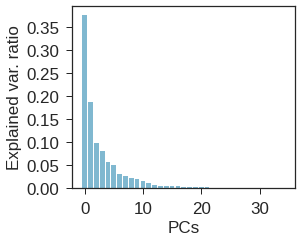

In [451]:
pca.get_covariance()

explained_variance=pca.explained_variance_ratio_
explained_variance

with plt.style.context('seaborn-white'):
    plt.style.use('seaborn-ticks')
    plt.figure(figsize=(5, 6))
    # plt.rcParams.update({'font.size': 50})
    plt.bar(range(35), explained_variance, alpha=0.5, align='center')
    plt.ylabel('Explained var. ratio', fontsize=17)
    plt.xlabel('PCs', fontsize=17)
    # plt.legend(loc='best')
    plt.tight_layout()
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.subplots_adjust(left=0.28, right=0.9, top=0.7, bottom=0.28)
    
plt.savefig('Explained_Variance.pdf')

In [452]:
print(abs( pca.components_ ))

[[0.10652181 0.24573756 0.25581585 ... 0.08703563 0.10696255 0.01103283]
 [0.29361598 0.1313087  0.09409377 ... 0.02319668 0.16474601 0.1924967 ]
 [0.04609399 0.06637882 0.08698959 ... 0.01988098 0.05712837 0.03043641]
 ...
 [0.08084086 0.02721087 0.05917607 ... 0.05526415 0.04165142 0.03406837]
 [0.76088552 0.00563328 0.00473428 ... 0.02254558 0.01613162 0.02831059]
 [0.04921211 0.00310674 0.0239404  ... 0.009549   0.00439584 0.00973608]]


In [453]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [454]:
#print(df['VALENCE'])

pca = PCA()
pca.fit(X_mdf_std_T)
X_PCA = pca.transform(X_mdf_std_T)

#print(pca.components_.T[:, 0])
#print(pca.components_.T[:, 1])
#print(pca.components_.T[:, 2])
# C1=pca.components_.T[:, 0]
# C2=pca.components_.T[:, 1]
# C3=pca.components_.T[:, 2]

# C4=pca.components_.T[:, 3]
# C5=pca.components_.T[:, 4]
# C6=pca.components_.T[:, 5]
# C7=pca.components_.T[:, 6]
# C8=pca.components_.T[:, 7]
# C9=pca.components_.T[:, 8]
# C10=pca.components_.T[:, 9]
# C11=pca.components_.T[:, 10]
# C12=pca.components_.T[:, 11]

C1=X_PCA[:,0]
C2=X_PCA[:,1]

print(C1.shape)

# crystalnames=[]
marker=[]
marker_explicit=[]

for pp in range (1,46):
    if pp==7 or pp==26 or pp==38 or pp==14 or pp==28 or pp==18 or pp==24:
        continue
        
    if pp==6 or pp==32 or pp==12:
        continue
        
    # crystalnames.append(crystal(pp))
    marker.append('OI')
    marker_explicit.append('circle')
    
for pp in range (1,46):
    if pp==7 or pp==26 or pp==38 or pp==14 or pp==28 or pp==18 or pp==24:
        continue
        
    if pp==6 or pp==32 or pp==12:
        continue
        
    # crystalnames.append(crystal(pp))
    marker.append('TI')
    marker_explicit.append('star-triangle-down')

# print(crystalnames)

PC_COMPS_2D = {
'PC1':C1,
'PC2':C2,
}

df_COMPS_2D=pd.DataFrame.from_dict(PC_COMPS_2D)
    
PC_COMPS_2D_half1 = {
'PC1':C1[:35],
'PC2':C2[:35],
}

PC_COMPS_2D_half2 = {
'PC1':C1[35:70],
'PC2':C2[35:70],
}
    
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=10),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=20),
    titlefont = dict(size=34)
)
axis_template_z=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=20),
    titlefont = dict(size=34)
)


# fig = px.scatter_3d(PC_COMPS, x='PC1', y='PC2', z='PC3', title="OT and IT PCA",text="crystal",color='VALENCE',symbol=marker)
# #fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',xaxis=axis_template_x,yaxis=axis_template_y,zaxis=axis_template_z)
# #fig.update_traces(marker_size = 3)
# fig.update_layout(
#     xaxis=axis_template_x,
#   font={"size":20})
# fig.update_layout(
#                  scene = dict(
#                                 xaxis = dict(
#                                      linewidth=1,
#                                      tickfont = dict(size=5),
#                                      backgroundcolor="rgba(0, 0, 0,0)",
#                                      gridcolor="grey",
#                                      showbackground=True,
#                                      zerolinecolor="white",),
#                                 yaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white"),
#                                 zaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white",),),
#                  )  
# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=-0.05
# ))
# fig.show()
# #plotly.offline.plot(fig, filename='/Users/dariomassa/Documents/PHD_NCBJ/FCC_new/SPIN_CHECK/PCA_OUT_CLUST.html')



(70,)


#### DIMENSIONALITY REDUCTION: TSNE

In [455]:
from sklearn.manifold import TSNE

tsne_3 = TSNE(n_components=3, perplexity=5,init='random',learning_rate='auto')
X_embedded_3 = tsne_3.fit_transform(X_mdf_std)

tsne_2 = TSNE(n_components=2, perplexity=5,init='random',learning_rate='auto')
X_embedded_2 = tsne_2.fit_transform(X_mdf_std)

In [456]:


tsne_3_EMB1=np.array(X_embedded_3[:,0])
tsne_3_EMB2=np.array(X_embedded_3[:,1])
tsne_3_EMB3=np.array(X_embedded_3[:,2])

tsne_2_EMB1=np.array(X_embedded_2[:,0])
tsne_2_EMB2=np.array(X_embedded_2[:,1])

tsne_3_EMB_half1 = {'EMB1':tsne_3_EMB1[:35],
         'EMB2':tsne_3_EMB2[:35],
         'EMB3':tsne_3_EMB3[:35],
          'Hrad': np.array(result['Rad_H'])[:35],
          'Mrad':np.array(result['Rad_M'])[:35],
          'Atomic Radius':np.array(result['Atomic Radius'])[:35],
          'Atomic Number':np.array(result['Atomic Number'])[:35],
          'VALENCE':np.array(result['VALENCE'])[:35],
          'B(kbar)':np.array(result['BULKM'])[:35],

        }

tsne_3_EMB_half2 = {'EMB1':tsne_3_EMB1[35:70],
         'EMB2':tsne_3_EMB2[35:70],
         'EMB3':tsne_3_EMB3[35:70],
          'Hrad': np.array(result['Rad_H'])[35:70],
          'Mrad':np.array(result['Rad_M'])[35:70],
          'Atomic Radius':np.array(result['Atomic Radius'])[35:70],
          'Atomic Number':np.array(result['Atomic Number'])[35:70],
          'VALENCE':np.array(result['VALENCE'])[35:70],
          'B(kbar)':np.array(result['BULKM'])[35:70],


        }

tsne_2_EMB_half1 = {'EMB1':tsne_2_EMB1[:35],
         'EMB2':tsne_2_EMB2[:35],
          'Hrad': np.array(result['Rad_H'])[:35],
          'Mrad':np.array(result['Rad_M'])[:35],
          'Atomic Radius':np.array(result['Atomic Radius'])[:35],
          'Atomic Number':np.array(result['Atomic Number'])[:35],
          'VALENCE':np.array(result['VALENCE'])[:35],
          'B(kbar)':np.array(result['BULKM'])[:35],

        }

tsne_2_EMB_half2 = {'EMB1':tsne_2_EMB1[35:70],
         'EMB2':tsne_2_EMB2[35:70],
          'Hrad': np.array(result['Rad_H'])[35:70],
          'Mrad':np.array(result['Rad_M'])[35:70],
          'Atomic Radius':np.array(result['Atomic Radius'])[35:70],
          'Atomic Number':np.array(result['Atomic Number'])[35:70],
          'VALENCE':np.array(result['VALENCE'])[35:70],
          'B(kbar)':np.array(result['BULKM'])[35:70],

        }


# axis_template_x=dict(
#     linecolor='black',
#     linewidth=2,
#     title="EMB1",
#     tickfont = dict(size=20),
#     titlefont = dict(size=34)
# )
# axis_template_y=dict(
#     linecolor='black',
#     linewidth=2,
#     tickfont = dict(size=20),
#     titlefont = dict(size=34),
#     title="EMB2"
# )

# trace1=go.Scatter3d(x=PC_EMB_half1['EMB1'],y=PC_EMB_half1['EMB2'],z=PC_EMB_half1['EMB3'],text=crystalnames,mode="markers+text",marker=dict(symbol='circle',showscale=True,color=PC_DF_half1["VALENCE"],colorbar=dict(title="VALENCE")),name="OI")
# trace2=go.Scatter3d(x=PC_EMB_half2['EMB1'],y=PC_EMB_half2['EMB2'],z=PC_EMB_half2['EMB3'],text=crystalnames,mode="markers+text",marker=dict(symbol='diamond',showscale=True,color=PC_DF_half1["VALENCE"],colorbar=dict(title="VALENCE")),name="TI")

#trace1=go.Scatter(x=PC_DF_half1['EMB1'],y=PC_DF_half1['EMB2'],text=crystalnames,mode="markers+text",marker=dict(symbol='circle',color='green'),name="OI")
#trace2=go.Scatter(x=PC_DF_half2['EMB1'],y=PC_DF_half2['EMB2'],text=crystalnames,mode="markers+text",marker=dict(symbol='circle',color='red'),name="TI")


In [457]:
# data=[trace1,trace2]

# fig = go.Figure(data=[trace1, trace2])

# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=-0.05
# ))
# fig.update_layout(showlegend=True)
# fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
# fig['layout'].update({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
# fig.update_traces(textposition='bottom center',textfont_size=34)
# fig.update_layout(title='3D TSNE with feature colouring',font={"size":21})
# fig.update_traces(marker=dict(size=12,line=dict(width=2)))
# fig.show()

# CLUSTERING

!pip install yellowbrick

### KMEANS

In [458]:
from sklearn.cluster import KMeans

# k_means_2_tot=KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(X_mdf_std)
# labels_2_tot=k_means_2_tot.labels_
# print(labels_2_tot)
# print(len(labels_2_tot))

# k_means_3_tot=KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(X_mdf_std)
# labels_3_tot=k_means_3_tot.labels_
# print(labels_3_tot)
# print(len(labels_3_tot))

# k_means_4_tot=KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(X_mdf_std)
# labels_4_tot=k_means_4_tot.labels_
# print(labels_4_tot)
# print(len(labels_4_tot))

# k_means_7_tot=KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(X_mdf_std)
# labels_7_tot=k_means_7_tot.labels_
# print(labels_7_tot)
# print(len(labels_7_tot))

# ///////////////////////////////////////////////////////////////

k_means_2_2DPCA=KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
labels_2_2DPCA=k_means_2_2DPCA.labels_
print(labels_2_2DPCA)
print(len(labels_2_2DPCA))

k_means_3_2DPCA=KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
labels_3_2DPCA=k_means_3_2DPCA.labels_
print(labels_3_2DPCA)
print(len(labels_3_2DPCA))

k_means_4_2DPCA=KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
labels_4_2DPCA=k_means_4_2DPCA.labels_
print(labels_4_2DPCA)
print(len(labels_4_2DPCA))

k_means_5_2DPCA=KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
labels_5_2DPCA=k_means_5_2DPCA.labels_
print(labels_5_2DPCA)
print(len(labels_5_2DPCA))

k_means_6_2DPCA=KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
labels_6_2DPCA=k_means_6_2DPCA.labels_
print(labels_6_2DPCA)
print(len(labels_6_2DPCA))

k_means_7_2DPCA=KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
labels_7_2DPCA=k_means_7_2DPCA.labels_
print(labels_7_2DPCA)
print(len(labels_7_2DPCA))

k_means_8_2DPCA=KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(df_COMPS_2D)
labels_8_2DPCA=k_means_8_2DPCA.labels_
print(labels_8_2DPCA)
print(len(labels_8_2DPCA))

[0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0
 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1]
70
[0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 2 0 0 2 0 0
 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 2 0 0 2]
70
[3 3 3 1 3 3 3 0 1 0 3 2 1 3 3 0 0 0 3 2 0 3 0 0 0 0 0 3 0 1 3 2 0 0 2 3 3
 3 1 3 3 3 0 1 0 0 2 1 3 3 0 0 0 3 2 0 0 0 0 0 0 0 0 0 3 0 2 0 0 2]
70
[0 0 0 4 0 0 0 1 4 1 3 2 4 0 0 1 1 3 0 2 3 3 1 1 1 3 1 3 3 0 1 2 3 3 2 0 0
 0 4 0 3 0 1 4 1 3 2 4 0 3 1 1 3 0 2 3 3 3 1 1 3 1 3 3 0 1 2 3 3 2]
70
[3 3 3 1 3 3 3 5 4 5 0 4 1 3 3 5 5 0 3 2 0 0 5 5 5 0 5 0 0 4 3 2 0 0 2 3 3
 3 1 3 0 3 5 4 5 0 4 1 3 0 5 5 0 0 2 0 0 0 5 5 0 5 0 0 4 5 2 0 0 2]
70
[5 5 1 0 1 1 5 4 3 4 1 3 0 1 1 4 4 1 1 2 6 1 4 4 4 1 4 1 6 3 1 2 6 6 2 5 5
 1 0 1 1 5 4 3 4 1 3 0 1 1 4 4 4 1 2 6 6 6 4 4 6 4 1 6 3 1 2 6 6 2]
70
[6 6 1 4 1 1 6 3 2 3 1 7 4 1 1 3 3 1 1 7 5 1 3 3 3 1 3 1 5 2 1 0 5 5 0 6 6
 1 4 1 1 6 3 2 3 1 7 4 1 1 3 3 3 1 7 5 5 5 3 3 5 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc714e75790>
Traceback (most recent call last):
  File "/home/massad/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/massad/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/massad/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/massad/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

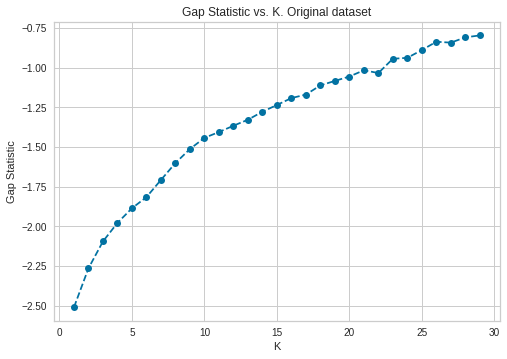

In [388]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def optimalK(data, nrefs, maxClusters):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):# Holder for reference dispersion results
        refDisps = np.zeros(nrefs)# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp# Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_# Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)# Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)

score_g, df = optimalK(X_mdf_std, 5, 30)
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K. Original dataset');

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc721f99ca0>
Traceback (most recent call last):
  File "/home/massad/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/massad/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/massad/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/massad/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

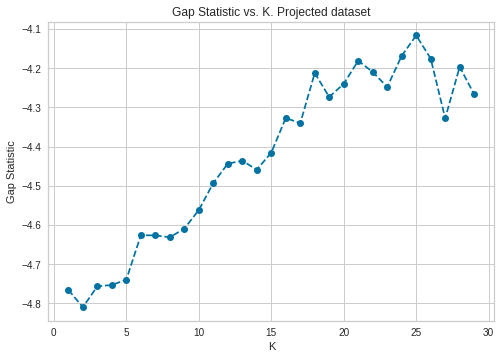

In [389]:
score_g, df = optimalK(df_COMPS_2D, 5, 30)
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K. Projected dataset');

ORIGINAL DATASET


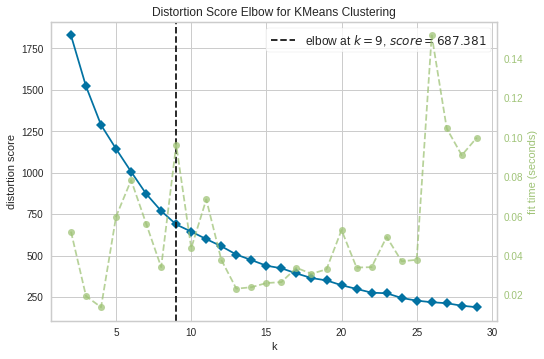

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [390]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(X_mdf_std)        # Fit data to visualizer
print("ORIGINAL DATASET")
visualizer.show() 

PROJECTED DATASET


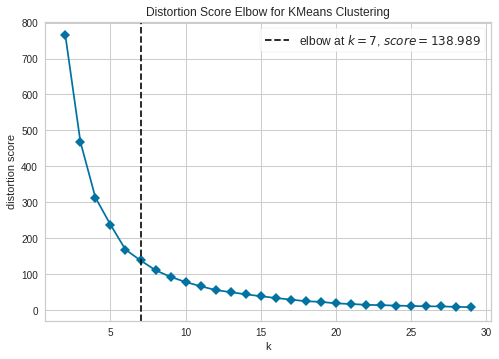

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [391]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= False)
visualizer.fit(df_COMPS_2D)        # Fit data to visualizer
print("PROJECTED DATASET")
visualizer.show() 

ORIGINAL DATASET


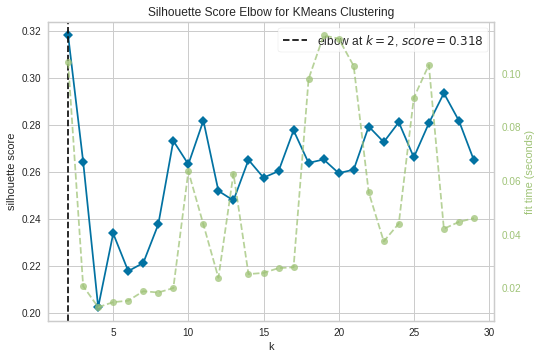

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [392]:
# Silhouette Score for K means# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(X_mdf_std)        # Fit the data to the visualizer
print("ORIGINAL DATASET")
visualizer.show()        # Finalize and render the figure

PROJECTED DATASET


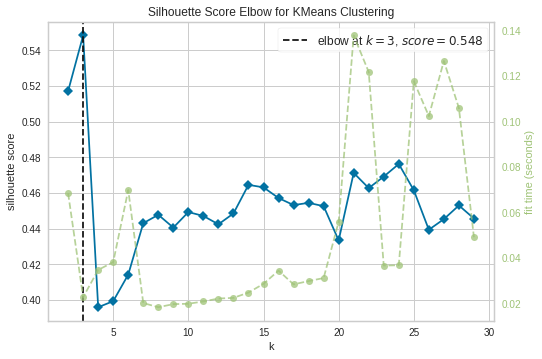

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [393]:
# Silhouette Score for K means# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(df_COMPS_2D)        # Fit the data to the visualizer
print("PROJECTED DATASET")
visualizer.show()        # Finalize and render the figure

ORIGINAL DATASET


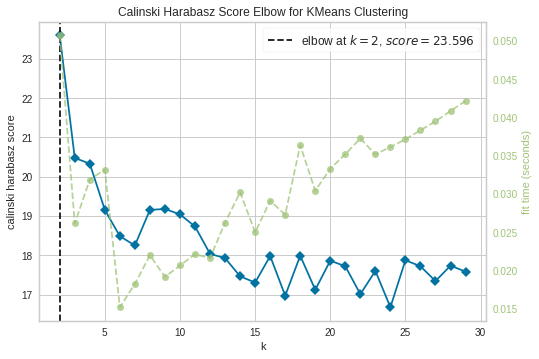

<AxesSubplot: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [394]:
# Calinski Harabasz Score for K means# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(X_mdf_std)        # Fit the data to the visualizer
print("ORIGINAL DATASET")
visualizer.show()

PROJECTED DATASET


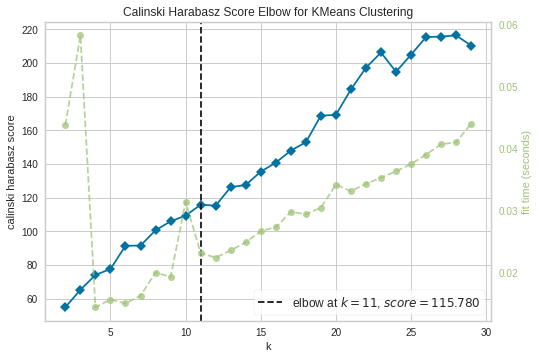

<AxesSubplot: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [395]:
# Calinski Harabasz Score for K means# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(df_COMPS_2D)        # Fit the data to the visualizer
print("PROJECTED DATASET")
visualizer.show()

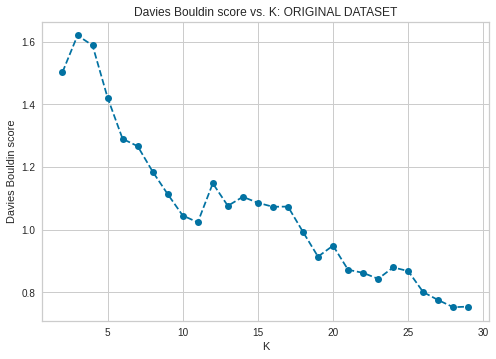

In [396]:
# Davies Bouldin score for K means
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)# Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    
    return score

scores = []
centers = list(range(2,30))
for center in centers:
    scores.append(get_kmeans_score(X_mdf_std, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K: ORIGINAL DATASET');

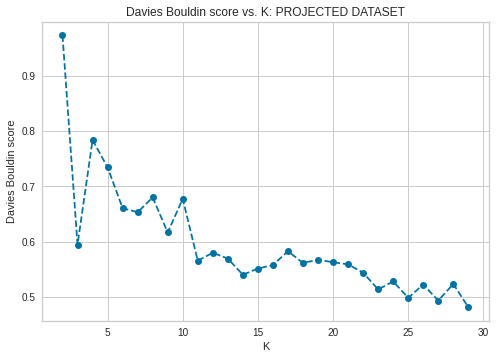

In [397]:
# Davies Bouldin score for K means
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)# Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    
    return score

scores = []
centers = list(range(2,30))
for center in centers:
    scores.append(get_kmeans_score(df_COMPS_2D, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K: PROJECTED DATASET');

/tmp/ipykernel_23541/1138045005.py:25: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



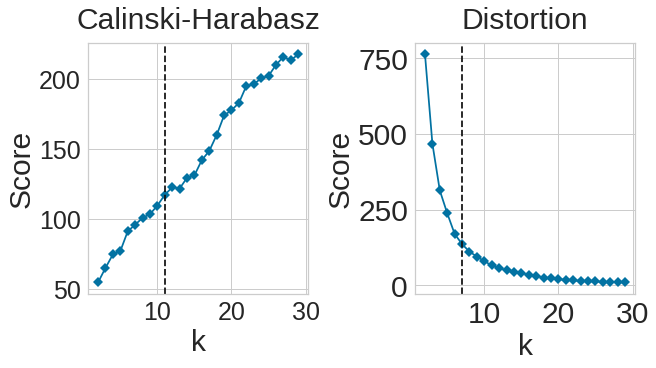

In [398]:
fig, axs = plt.subplots(figsize=(9, 5),nrows=1, ncols=2, constrained_layout=True)

i=0
for ax in axs.flat:
    i+=1
    if i==1:
        ax.set_xlabel('k', fontsize=30)
        ax.set_ylabel('Score', fontsize=30)
        ax.set_title('Calinski-Harabasz', fontsize=30,y=1.0, pad=+14)
        ax.tick_params(axis='both', which='major', labelsize=25)
        # ax.tick_params(axis='both', which='minor', labelsize=30)
        visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= False, ax=ax)
        visualizer.fit(df_COMPS_2D)
    if i==2:
        ax.set_xlabel('k', fontsize=30)
        ax.set_ylabel('Score', fontsize=30)
        ax.set_title('Distortion', fontsize=30, y=1.0, pad=+14)
        ax.tick_params(axis='both', which='major', labelsize=30)
        # ax.tick_params(axis='both', which='minor', labelsize=30)
        visualizer = KElbowVisualizer(model, k=(2,30), timings= False, ax=ax)
        visualizer.fit(df_COMPS_2D)        # Fit data to visualizer
        
# plt.subplots_adjust(bottom=0.1, right=1.0, top=0.9)

fig.show()
# plt.savefig('Scores_KMEANS_bestN.png')

/tmp/ipykernel_23541/2326525126.py:13: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



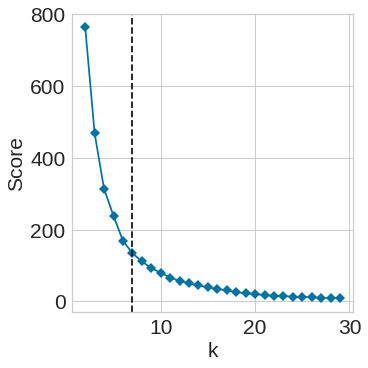

In [399]:
fig, ax = plt.subplots(figsize=(5, 5),nrows=1, ncols=1, constrained_layout=True)

ax.set_xlabel('k', fontsize=21)
ax.set_ylabel('Score', fontsize=21)
# ax.set_title('Elbow', fontsize=21, y=1.0, pad=+14)
ax.tick_params(axis='both', which='major', labelsize=21)
# ax.tick_params(axis='both', which='minor', labelsize=30)
visualizer = KElbowVisualizer(model, k=(2,30), timings= False, ax=ax)
visualizer.fit(df_COMPS_2D)        # Fit data to visualizer
        
# plt.subplots_adjust(bottom=0.1, right=1.0, top=0.9)

fig.show()
# plt.savefig('Scores_KMEANS_bestN_1.png')

In [148]:
# fig = px.scatter_3d(PC_COMPS, x='PC1', y='PC2', z='PC3', title="OT and IT PCA: K-Means on complete dataset",text="crystal",color=labels_2_tot,symbol=marker)
# #fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',xaxis=axis_template_x,yaxis=axis_template_y,zaxis=axis_template_z)
# #fig.update_traces(marker_size = 3)
# fig.update_layout(
#     xaxis=axis_template_x,
#   font={"size":20})
# fig.update_layout(
#                  scene = dict(
#                                 xaxis = dict(
#                                      linewidth=1,
#                                      tickfont = dict(size=5),
#                                      backgroundcolor="rgba(0, 0, 0,0)",
#                                      gridcolor="grey",
#                                      showbackground=True,
#                                      zerolinecolor="white",),
#                                 yaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white"),
#                                 zaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white",),),
#                  )  

# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=0.05
# ))

# fig.show()

In [60]:
# fig = px.scatter(PC_COMPS, x='PC1', y='PC2', title="OT and IT PCA: K-Means on complete dataset",text="crystal",color=labels_2_tot,symbol=marker)
# #fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',xaxis=axis_template_x,yaxis=axis_template_y,zaxis=axis_template_z)
# #fig.update_traces(marker_size = 3)
# fig.update_layout(
#     xaxis=axis_template_x,
#   font={"size":34})
# fig.update_layout(
#                  scene = dict(
#                                 xaxis = dict(
#                                      linewidth=1,
#                                      tickfont = dict(size=34),
#                                      backgroundcolor="rgba(0, 0, 0,0)",
#                                      gridcolor="grey",
#                                      showbackground=True,
#                                      zerolinecolor="white",),
#                                 yaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=34),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white"),
#                                 zaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=34),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white",),),
#                  )  

# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=0.05
# ))

# fig.show()

In [61]:
# from sklearn.cluster import KMeans

# K_M_PCA_DF={'PC1':C1,
#             'PC2':C2,
#             'PC3':C3}
# K_M_PCA_DF=pd.DataFrame.from_dict(K_M_PCA_DF)#K_M_PCA_DF
# k_means=KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(K_M_PCA_DF)
# labels_2=k_means.labels_

# print(labels_2)
# print(len(labels_2))

# fig = px.scatter_3d(PC_COMPS, x='PC1', y='PC2', z='PC3', title="K-Means on PCA reduced space",text="crystal",color=labels_2,symbol=marker)
# #fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',xaxis=axis_template_x,yaxis=axis_template_y,zaxis=axis_template_z)
# #fig.update_traces(marker_size = 3)
# fig.update_layout(
#     xaxis=axis_template_x,
#   font={"size":20})
# fig.update_layout(
#                  scene = dict(
#                                 xaxis = dict(
#                                      linewidth=1,
#                                      tickfont = dict(size=5),
#                                      backgroundcolor="rgba(0, 0, 0,0)",
#                                      gridcolor="grey",
#                                      showbackground=True,
#                                      zerolinecolor="white",),
#                                 yaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white"),
#                                 zaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white",),),
#                  )  

# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=0.32
# ))

# fig.show()
# plotly.offline.plot(fig, filename='./KM+PCA_123.html')

In [62]:
# from sklearn.cluster import KMeans

# K_M_PCA_DF={'PC1':C1,
#             'PC2':C2,
#             'PC3':C3}
# K_M_PCA_DF=pd.DataFrame.from_dict(K_M_PCA_DF)
# k_means=KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(K_M_PCA_DF)
# labels_2=k_means.labels_

# print(labels_2)
# print(len(labels_2))

# fig = px.scatter(PC_COMPS, x='PC1', y='PC2', title="K-Means on PCA reduced space",text="crystal",color=labels_2,symbol=marker_explicit)
# #fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',xaxis=axis_template_x,yaxis=axis_template_y,zaxis=axis_template_z)
# #fig.update_traces(marker_size = 3)
# fig.update_layout(
#     xaxis=axis_template_x,
#   font={"size":20})
# fig.update_layout(
#                  scene = dict(
#                                 xaxis = dict(
#                                      linewidth=1,
#                                      tickfont = dict(size=5),
#                                      backgroundcolor="rgba(0, 0, 0,0)",
#                                      gridcolor="grey",
#                                      showbackground=True,
#                                      zerolinecolor="white",),
#                                 yaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white")
#                  ))  

# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=0.32
# ))

# fig.show()
# plotly.offline.plot(fig, filename='./KM+PCA_123_2D.html')

In [63]:
# fig = px.scatter_3d(PC_COMPS, x='PC1', y='PC4', z='PC5', title="K-Means on PCA reduced space",text="crystal",color=labels_2,symbol=marker)
# #fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',xaxis=axis_template_x,yaxis=axis_template_y,zaxis=axis_template_z)
# #fig.update_traces(marker_size = 3)
# fig.update_layout(
#     xaxis=axis_template_x,
#   font={"size":20})
# fig.update_layout(
#                  scene = dict(
#                                 xaxis = dict(
#                                      linewidth=1,
#                                      tickfont = dict(size=5),
#                                      backgroundcolor="rgba(0, 0, 0,0)",
#                                      gridcolor="grey",
#                                      showbackground=True,
#                                      zerolinecolor="white",),
#                                 yaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white"),
#                                 zaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white",),),
#                  )  
# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=0.32
# ))
# fig.show()
# plotly.offline.plot(fig, filename='./KM+PCA_145.html')

In [64]:
# fig = px.scatter_3d(PC_COMPS, x='PC1', y='PC6', z='PC7', title="K-Means on PCA reduced space",text="crystal",color=labels_2,symbol=marker)
# #fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',xaxis=axis_template_x,yaxis=axis_template_y,zaxis=axis_template_z)
# #fig.update_traces(marker_size = 3)
# fig.update_layout(
#     xaxis=axis_template_x,
#   font={"size":20})
# fig.update_layout(
#                  scene = dict(
#                                 xaxis = dict(
#                                      linewidth=1,
#                                      tickfont = dict(size=5),
#                                      backgroundcolor="rgba(0, 0, 0,0)",
#                                      gridcolor="grey",
#                                      showbackground=True,
#                                      zerolinecolor="white",),
#                                 yaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white"),
#                                 zaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white",),),
#                  )  
# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=0.32
# ))
# fig.show()
# plotly.offline.plot(fig, filename='./KM+PCA_167.html')

In [65]:
# # trace1=go.Scatter(x=PC_EMB_half1['EMB1'],y=PC_EMB_half1['EMB2'],text=crystalnames,mode="markers+text",marker=dict(symbol='circle',showscale=True,color=labels_2,colorbar=dict(title="LABELS")),name="OI")
# # trace2=go.Scatter(x=PC_EMB_half2['EMB1'],y=PC_EMB_half2['EMB2'],text=crystalnames,mode="markers+text",marker=dict(symbol='star-triangle-down',showscale=True,color=labels_2,colorbar=dict(title="LABELS")),name="TI")

# trace1=go.Scatter3d(x=PC_EMB_half1['EMB1'],y=PC_EMB_half1['EMB2'],z=PC_EMB_half1['EMB3'],text=crystalnames,mode="markers+text",marker=dict(symbol='circle',showscale=True,color=labels_2,colorbar=dict(title="VALENCE")),name="OI")
# trace2=go.Scatter3d(x=PC_EMB_half2['EMB1'],y=PC_EMB_half2['EMB2'],z=PC_EMB_half2['EMB3'],text=crystalnames,mode="markers+text",marker=dict(symbol='diamond',showscale=True,color=labels_2,colorbar=dict(title="VALENCE")),name="TI")

# data=[trace1,trace2]

# fig = go.Figure(data=[trace1, trace2])

# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=-0.05
# ))
# fig.update_layout(showlegend=True)
# fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
# fig['layout'].update({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
# fig.update_traces(textposition='bottom center',textfont_size=34)
# fig.update_layout(font={"size":21})
# fig.update_traces(marker=dict(size=12,line=dict(width=2)))
# fig.show()

In [66]:
# trace1_1 = go.Scatter3d(opacity=1.0,name='OI',showlegend=True,x=PC_COMPS_2D_half1["PC1"], y=PC_COMPS_2D_half1["PC2"], z=PC_COMPS_2D_half1["PC3"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='circle',color=labels_2[:45]))
# trace1_2 = go.Scatter3d(opacity=1.0,name='TI',showlegend=True,x=PC_COMPS_2D_half2["PC1"], y=PC_COMPS_2D_half2["PC2"], z=PC_COMPS_2D_half2["PC3"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='diamond',color=labels_2[45:90]))

# trace2_1 = go.Scatter3d(opacity=1.0,showlegend=False,x=PC_COMPS_2D_half1["PC1"], y=PC_COMPS_2D_half1["PC4"], z=PC_COMPS_2D_half1["PC5"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='circle',color=labels_2[:45]))
# trace2_2 = go.Scatter3d(opacity=1.0,showlegend=False,x=PC_COMPS_2D_half2["PC1"], y=PC_COMPS_2D_half2["PC4"], z=PC_COMPS_2D_half2["PC5"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='diamond',color=labels_2[45:90]))

# trace3_1 = go.Scatter3d(opacity=1.0,showlegend=False,x=PC_COMPS_2D_half1["PC1"], y=PC_COMPS_2D_half1["PC6"], z=PC_COMPS_2D_half1["PC7"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='circle',color=labels_2[:45]))
# trace3_2 = go.Scatter3d(opacity=1.0,showlegend=False,x=PC_COMPS_2D_half2["PC1"], y=PC_COMPS_2D_half2["PC6"], z=PC_COMPS_2D_half2["PC7"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='diamond',color=labels_2[45:90]))


# fig = make_subplots(
#     rows=1, cols=3,
#     specs=[[{"type": "scatter3d"}, {"type": "scatter3d"},{"type": "scatter3d"}]],
#     horizontal_spacing = 0.03
# )

# data = [trace1_1,trace1_2,trace2_1,trace2_2,trace3_1,trace3_2]


# fig.append_trace(trace1_1,row=1,col=1)
# fig.append_trace(trace1_2,row=1,col=1)
# fig.append_trace(trace2_1,row=1,col=2)
# fig.append_trace(trace2_2,row=1,col=2)
# fig.append_trace(trace3_1,row=1,col=3)
# fig.append_trace(trace3_2,row=1,col=3)

# fig.update_xaxes(linecolor='black',title_text="PC1",showgrid=False, row=1, col=1)
# fig.update_xaxes(title_text="PC1",showgrid=False, row=2, col=1)
# fig.update_xaxes(title_text="PC1", showgrid=False, row=3, col=1)
# fig.update_yaxes(title_text="PC2",showgrid=False, row=1, col=1)
# fig.update_yaxes(title_text="PC4",showgrid=False, row=2, col=1)
# fig.update_yaxes(title_text="PC6", showgrid=False, row=3, col=1)
# fig.update_yaxes(title_text="PC3",showgrid=False, row=1, col=1)
# fig.update_yaxes(title_text="PC5",showgrid=False, row=2, col=1)
# fig.update_yaxes(title_text="PC7", showgrid=False, row=3, col=1)

# fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

# fig.update_layout(scene=dict(
# bgcolor='white',
# xaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC1"),
# yaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC2"),
# zaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC3"),
# ),
# scene2=dict(
# # {'plot_bgcolor': 'rgba(0, 0, 0, 0)'},
# xaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC1"),
# yaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC4"),
# zaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC5"),
# ),
# scene3=dict(
# # {'plot_bgcolor': 'rgba(0, 0, 0, 0)'},
# xaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC1"),
# yaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC6"),
# zaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC7"),
# )                 )

# fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})

# fig.update_traces(textposition='top center',textfont_size=1)

# fig.update_layout(font={"size":34})

# fig.update_traces(marker=dict(size=12,line=dict(width=2)))

# fig.show()

# #fig.layout.coloraxis.colorbar.title = 'B(kbar)'

# #fig.update_traces(marker=dict(size=12,line=dict(width=2)))

# # plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/PCA_1.html')




In [67]:
# trace1_1 = go.Scatter3d(opacity=1.0,name='OI',showlegend=True,x=PC_COMPS_2D_half1["PC1"], y=PC_COMPS_2D_half1["PC2"], z=PC_COMPS_2D_half1["PC3"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='circle',color=labels_2[:45]))
# trace1_2 = go.Scatter3d(opacity=1.0,name='TI',showlegend=True,x=PC_COMPS_2D_half2["PC1"], y=PC_COMPS_2D_half2["PC2"], z=PC_COMPS_2D_half2["PC3"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='diamond',color=labels_2[45:90]))

# trace2_1 = go.Scatter3d(opacity=1.0,showlegend=False,x=PC_COMPS_2D_half1["PC1"], y=PC_COMPS_2D_half1["PC2"], z=PC_COMPS_2D_half1["PC3"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='circle',color=PC_COMPS_2D_half1["VALENCE"]))
# trace2_2 = go.Scatter3d(opacity=1.0,showlegend=False,x=PC_COMPS_2D_half2["PC1"], y=PC_COMPS_2D_half2["PC2"], z=PC_COMPS_2D_half2["PC3"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='diamond',color=PC_COMPS_2D_half2["VALENCE"]))

# trace3_1 = go.Scatter3d(opacity=1.0,showlegend=False,x=PC_COMPS_2D_half1["PC1"], y=PC_COMPS_2D_half1["PC2"], z=PC_COMPS_2D_half1["PC3"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='circle',color=PC_COMPS_2D_half1["BULKM"]))
# trace3_2 = go.Scatter3d(opacity=1.0,showlegend=False,x=PC_COMPS_2D_half2["PC1"], y=PC_COMPS_2D_half2["PC2"], z=PC_COMPS_2D_half2["PC3"],mode="markers+text",marker=dict(size=12,line=dict(width=2),symbol='diamond',color=PC_COMPS_2D_half2["BULKM"]))


# fig = make_subplots(
#     rows=1, cols=3,
#     specs=[[{"type": "scatter3d"}, {"type": "scatter3d"},{"type": "scatter3d"}]],
#     horizontal_spacing = 0.03
# )

# data = [trace1_1,trace1_2,trace2_1,trace2_2,trace3_1,trace3_2]


# fig.append_trace(trace1_1,row=1,col=1)
# fig.append_trace(trace1_2,row=1,col=1)
# fig.append_trace(trace2_1,row=1,col=2)
# fig.append_trace(trace2_2,row=1,col=2)
# fig.append_trace(trace3_1,row=1,col=3)
# fig.append_trace(trace3_2,row=1,col=3)

# fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

# fig.update_layout(scene=dict(
# bgcolor='white',
# xaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC1"),
# yaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC2"),
# zaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC3"),
# ),
# scene2=dict(
# # {'plot_bgcolor': 'rgba(0, 0, 0, 0)'},
# xaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC1"),
# yaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC4"),
# zaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC5"),
# ),
# scene3=dict(
# # {'plot_bgcolor': 'rgba(0, 0, 0, 0)'},
# xaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC1"),
# yaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC6"),
# zaxis=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=1),titlefont = dict(size=34),title="PC7"),
# )                 )

# fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})

# fig.update_traces(textposition='top center',textfont_size=1)

# fig.update_layout(font={"size":34})

# fig.update_traces(marker=dict(size=12,line=dict(width=2)))

# fig.show()

# #fig.layout.coloraxis.colorbar.title = 'B(kbar)'

# #fig.update_traces(marker=dict(size=12,line=dict(width=2)))

# # plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/PCA_2.html')




In [68]:
# pd.DataFrame(pca.components_.T)

### Gaussian Mixture

In [400]:
from sklearn.mixture import GaussianMixture

# G_M_PCA_DF={'PC1':C1,
#             'PC2':C2,
#             'PC3':C3}
# G_M_PCA_DF=pd.DataFrame.from_dict(G_M_PCA_DF)

# gmix_2_tot=GaussianMixture(n_components=2,random_state=0).fit_predict(X_mdf_std)

# gmix_3_tot=GaussianMixture(n_components=3,random_state=0).fit_predict(X_mdf_std)

# gmix_4_tot=GaussianMixture(n_components=4,random_state=0).fit_predict(X_mdf_std)

# gmix_7_tot=GaussianMixture(n_components=7,random_state=0).fit_predict(X_mdf_std)

# print(gmix_2_tot)
# print(gmix_3_tot)
# print(gmix_4_tot)
# print(gmix_7_tot)

gmix_2_2DPCA=GaussianMixture(n_components=2,random_state=0).fit_predict(df_COMPS_2D)

gmix_3_2DPCA=GaussianMixture(n_components=3,random_state=0).fit_predict(df_COMPS_2D)

gmix_4_2DPCA=GaussianMixture(n_components=4,random_state=0).fit_predict(df_COMPS_2D)

gmix_5_2DPCA=GaussianMixture(n_components=5,random_state=0).fit_predict(df_COMPS_2D)

gmix_6_2DPCA=GaussianMixture(n_components=6,random_state=0).fit_predict(df_COMPS_2D)

gmix_7_2DPCA=GaussianMixture(n_components=7,random_state=0).fit_predict(df_COMPS_2D)

gmix_8_2DPCA=GaussianMixture(n_components=8,random_state=0).fit_predict(df_COMPS_2D)

print(gmix_2_2DPCA)
print(gmix_3_2DPCA)
print(gmix_4_2DPCA)
print(gmix_5_2DPCA)
print(gmix_6_2DPCA)
print(gmix_7_2DPCA)
print(gmix_8_2DPCA)

# fig = px.scatter_3d(PC_COMPS, x='PC1', y='PC2', z='PC3', title="Gaussian-Mixture on PCA reduced space",text="crystal",color=gmix,symbol=marker)
# #fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',xaxis=axis_template_x,yaxis=axis_template_y,zaxis=axis_template_z)
# #fig.update_traces(marker_size = 3)
# fig.update_layout(
#     xaxis=axis_template_x,
#   font={"size":20})
# fig.update_layout(
#                  scene = dict(
#                                 xaxis = dict(
#                                      linewidth=1,
#                                      tickfont = dict(size=5),
#                                      backgroundcolor="rgba(0, 0, 0,0)",
#                                      gridcolor="grey",
#                                      showbackground=True,
#                                      zerolinecolor="white",),
#                                 yaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white"),
#                                 zaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white",),),
#                  )  

# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=0.32
# ))

# fig.show()
# plotly.offline.plot(fig, filename='./GM+PCA.html')

[0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0
 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1]
[0 0 0 2 0 0 0 0 2 0 0 1 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 1 0 0 1 0 0
 0 2 0 0 0 0 2 0 0 1 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 1 0 0 1]
[3 3 3 2 3 3 3 0 2 0 3 1 2 3 3 0 0 3 3 1 3 3 0 0 0 3 0 3 3 2 3 1 3 3 1 3 3
 3 2 3 3 3 0 2 0 3 1 2 3 3 0 0 3 3 1 3 3 0 0 0 3 0 3 3 2 3 1 3 3 1]
[3 3 3 2 3 3 3 0 2 0 3 1 2 3 3 0 0 3 3 1 3 3 0 0 0 3 0 3 4 2 3 1 4 4 1 3 3
 3 2 3 3 3 0 2 0 3 1 2 3 3 0 0 3 3 1 4 4 0 0 0 3 0 4 4 2 3 1 4 4 1]
[3 3 3 2 3 3 3 0 5 0 3 5 2 3 3 0 0 3 3 1 3 3 0 0 0 3 0 3 4 5 3 1 4 4 1 3 3
 3 2 3 3 3 0 5 0 3 5 2 3 3 0 0 3 3 1 4 4 0 0 0 4 0 3 4 5 3 1 4 4 1]
[3 3 3 2 3 3 3 0 5 0 3 5 2 3 3 0 0 3 3 1 3 3 0 0 0 3 0 3 4 5 3 6 4 4 6 3 3
 3 2 3 3 3 0 5 0 3 5 2 3 3 0 0 3 3 1 4 4 0 0 0 4 0 3 4 5 3 6 4 4 6]
[7 7 3 2 3 3 7 0 5 0 3 5 2 3 3 0 0 3 3 1 4 4 0 0 3 3 0 4 4 5 3 6 4 4 6 7 7
 3 2 3 3 3 0 5 0 3 5 2 3 3 0 0 3 3 1 4 4 0 0 0 4 0 4 4 5 3 6 4 4 6]

In [167]:
# from sklearn.mixture import GaussianMixture

# G_M_PCA_DF={'PC1':C1,
#             'PC2':C2,
#             'PC3':C3}
# G_M_PCA_DF=pd.DataFrame.from_dict(G_M_PCA_DF)

# gmix=GaussianMixture(n_components=3, n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None).fit_predict(G_M_PCA_DF)

# print(gmix)
# # print(gmix.means_)

# # for i, color in enumerate('rgb'):
# #     # sphere background
# #     width, height = 2 * 1.96 * np.sqrt(np.diagonal(gmm._get_covars()[i]))
# #     ell = mpl.patches.Ellipse(gmm.means_[i], width, height, color=color)
# #     ell.set_alpha(0.1)
# #     ax.add_artist(ell)
# #     # data points
# #     X_data = X[y_pred == i]
# #     ax.scatter(X_data[:,0], X_data[:,1], color=color)
# #     # center
# #     ax.scatter(gmm.means_[i][0], gmm.means_[i][1], marker='x', s=100, c=color)

# fig = px.scatter_3d(PC_COMPS, x='PC1', y='PC2', z='PC3', title="Gaussian-Mixture (refined param.s) on PCA reduced space",text="crystal",color=gmix,symbol=marker)
# #fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',xaxis=axis_template_x,yaxis=axis_template_y,zaxis=axis_template_z)
# #fig.update_traces(marker_size = 3)
# fig.update_layout(
#     xaxis=axis_template_x,
#   font={"size":20})
# fig.update_layout(
#                  scene = dict(
#                                 xaxis = dict(
#                                      linewidth=1,
#                                      tickfont = dict(size=5),
#                                      backgroundcolor="rgba(0, 0, 0,0)",
#                                      gridcolor="grey",
#                                      showbackground=True,
#                                      zerolinecolor="white",),
#                                 yaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white"),
#                                 zaxis = dict(
#                                      linewidth=1,
#                                     tickfont = dict(size=5),
#                                     backgroundcolor="rgba(0, 0, 0,0)",
#                                     gridcolor="grey",
#                                     showbackground=True,
#                                     zerolinecolor="white",),),
#                  )  


# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=0.32
# ))

# # fig.add_shape(type="circle",
# #     xref="x", yref="y", zref='z',
# #     x0=min(PC_COMPS['PC1']), y0=min(PC_COMPS['PC2']), z0=min(PC_COMPS['PC3']),
# #     x1=max(PC_COMPS['PC1']), y1=max(PC_COMPS['PC2']), z1=max(PC_COMPS['PC3']),
# #     opacity=0.2,
# #     fillcolor="blue",
# #     line_color="blue",
# # )

# A = np.array([PC_COMPS['PC1'],
#               PC_COMPS['PC2'],
#               PC_COMPS['PC3']])
# A=A.T
# center = [0.0470253,0.02538793,-0.00956732] #[indx*np.random.random_sample(),indx*np.random.random_sample(),indx*np.random.random_sample()]

# # find the rotation matrix and radii of the axes
# U, s, rotation = np.linalg.svd(A)
# radii = 1.0/np.sqrt(s) * 0.25 #reduce radii by factor 0.3 

# # calculate cartesian coordinates for the ellipsoid surface
# u = np.linspace(0.0, 2.0 * np.pi, 60)
# v = np.linspace(0.0, np.pi, 60)
# x = radii[0] * np.outer(np.cos(u), np.sin(v))
# y = radii[1] * np.outer(np.sin(u), np.sin(v))
# z = radii[2] * np.outer(np.ones_like(u), np.cos(v))

# for i in range(len(x)):
#     for j in range(len(x)):
#         [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center


# # ax.plot_surface(x, y, z,  rstride=3, cstride=3,  color=m.to_rgba(indx), linewidth=0.1, alpha=1, shade=True)
# # fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.25))


# A = np.array([PC_COMPS['PC1'],
#               PC_COMPS['PC2'],
#               PC_COMPS['PC3']])
# A=A.T
# center = [-0.14185957,-0.0482644,0.00085049] #[indx*np.random.random_sample(),indx*np.random.random_sample(),indx*np.random.random_sample()]

# # find the rotation matrix and radii of the axes
# U, s, rotation = np.linalg.svd(A)
# radii = 1.0/np.sqrt(s) * 0.25 #reduce radii by factor 0.3 

# # calculate cartesian coordinates for the ellipsoid surface
# u = np.linspace(0.0, 2.0 * np.pi, 60)
# v = np.linspace(0.0, np.pi, 60)
# x = radii[0] * np.outer(np.cos(u), np.sin(v))
# y = radii[1] * np.outer(np.sin(u), np.sin(v))
# z = radii[2] * np.outer(np.ones_like(u), np.cos(v))

# for i in range(len(x)):
#     for j in range(len(x)):
#         [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center


# # ax.plot_surface(x, y, z,  rstride=3, cstride=3,  color=m.to_rgba(indx), linewidth=0.1, alpha=1, shade=True)
# # fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.25))


# A = np.array([PC_COMPS['PC1'],
#               PC_COMPS['PC2'],
#               PC_COMPS['PC3']])
# A=A.T
# center = [-0.06984664,-0.33749018,0.31069386] #[indx*np.random.random_sample(),indx*np.random.random_sample(),indx*np.random.random_sample()]

# # find the rotation matrix and radii of the axes
# U, s, rotation = np.linalg.svd(A)
# radii = 1.0/np.sqrt(s) * 0.25 #reduce radii by factor 0.3 

# # calculate cartesian coordinates for the ellipsoid surface
# u = np.linspace(0.0, 2.0 * np.pi, 60)
# v = np.linspace(0.0, np.pi, 60)
# x = radii[0] * np.outer(np.cos(u), np.sin(v))
# y = radii[1] * np.outer(np.sin(u), np.sin(v))
# z = radii[2] * np.outer(np.ones_like(u), np.cos(v))

# for i in range(len(x)):
#     for j in range(len(x)):
#         [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center


# # ax.plot_surface(x, y, z,  rstride=3, cstride=3,  color=m.to_rgba(indx), linewidth=0.1, alpha=1, shade=True)
# # fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.25))


# fig.show()
# plotly.offline.plot(fig, filename='./GM+PCA_refined.html')

# # GaussianMixture(max_iter=300, n_components=3, n_init=10, tol=0.0001)
# # [[ 0.0470253   0.02538793 -0.00956732]
# #  [-0.14185957 -0.0482644   0.00085049]
# #  [-0.06984664 -0.33749018  0.31069386]]


In [168]:
# init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto'

In [169]:
# # trace1=go.Scatter(x=PC_EMB_half1['EMB1'],y=PC_EMB_half1['EMB2'],text=crystalnames,mode="markers+text",marker=dict(symbol='circle',showscale=True,color=gmix,colorbar=dict(title="LABELS")),name="OI")
# # trace2=go.Scatter(x=PC_EMB_half2['EMB1'],y=PC_EMB_half2['EMB2'],text=crystalnames,mode="markers+text",marker=dict(symbol='star-triangle-down',showscale=True,color=gmix,colorbar=dict(title="LABELS")),name="TI")

# trace1=go.Scatter3d(x=PC_EMB_half1['EMB1'],y=PC_EMB_half1['EMB2'],z=PC_EMB_half1['EMB3'],text=crystalnames,mode="markers+text",marker=dict(symbol='circle',showscale=True,color=gmix,colorbar=dict(title="VALENCE")),name="OI")
# trace2=go.Scatter3d(x=PC_EMB_half2['EMB1'],y=PC_EMB_half2['EMB2'],z=PC_EMB_half2['EMB3'],text=crystalnames,mode="markers+text",marker=dict(symbol='diamond',showscale=True,color=gmix,colorbar=dict(title="VALENCE")),name="TI")


# data=[trace1,trace2]

# fig = go.Figure(data=[trace1, trace2])

# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=1.00,
#     xanchor="right",
#     x=-0.05
# ))
# fig.update_layout(showlegend=True)
# fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
# fig['layout'].update({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
# fig.update_traces(textposition='bottom center',textfont_size=34)
# fig.update_layout(font={"size":21})
# fig.update_traces(marker=dict(size=12,line=dict(width=2)))
# fig.show()

# PLOTTING

In [170]:
# labels = {
#     str(i): f"PC {i+1} ({var:.1f}%)"
#     for i, var in enumerate(pca_12.explained_variance_ratio_ * 100)
# }

# fig = px.scatter_matrix(
#     components,
#     # labels=labels,
#     dimensions=range(13),
#     # color=df["species"]
# )
# fig.update_traces(diagonal_visible=False)
# fig.show()

trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=labels_2_tot,colorbar=dict(title=".",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=labels_2_tot),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=gmix_2_tot,colorbar=dict(title=".")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=gmix_2_tot),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=2)',  'Gaussian-Mixture(n=2)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)
fig.show()
# plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl2_tot_VS_GM_cl2_tot_onPCA.html')

In [154]:
trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=labels_2_2DPCA,colorbar=dict(title=".",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=labels_2_2DPCA),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=gmix_2_2DPCA,colorbar=dict(title=".")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=gmix_2_2DPCA),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=2)',  'Gaussian-Mixture(n=2)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)
fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl2_2DPC_VS_GM_cl2_2DPCA_onPCA.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl2_2DPC_VS_GM_cl2_2DPCA_onPCA.html'

trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=labels_3_tot,colorbar=dict(title=".",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=labels_3_tot),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=gmix_3_tot,colorbar=dict(title=".")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=gmix_3_tot),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=3)',  'Gaussian-Mixture(n=3)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)
fig.show()
# plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl3_tot_VS_GM_cl3_tot_onPCA.html')

In [155]:
trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=labels_3_2DPCA,colorbar=dict(title=".",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=labels_3_2DPCA),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=gmix_3_2DPCA,colorbar=dict(title=".")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=gmix_3_2DPCA),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=3)',  'Gaussian-Mixture(n=3)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)
fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl3_2DPC_VS_GM_cl3_2DPC_onPCA.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl3_2DPC_VS_GM_cl3_2DPC_onPCA.html'

trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=labels_4_tot,colorbar=dict(title=".",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=labels_4_tot),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=gmix_4_tot,colorbar=dict(title=".")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=gmix_4_tot),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=4)',  'Gaussian-Mixture(n=4)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)
fig.show()
# plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl4_tot_VS_GM_cl4_tot_onPCA.html')

In [156]:
trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=labels_4_2DPCA,colorbar=dict(title=".",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=labels_4_2DPCA),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=gmix_4_2DPCA,colorbar=dict(title=".")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=gmix_4_2DPCA),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=4)',  'Gaussian-Mixture(n=4)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)
fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl4_2DPCA_VS_GM_cl4_2DPCA_onPCA.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl4_2DPCA_VS_GM_cl4_2DPCA_onPCA.html'

trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=labels_7_tot,colorbar=dict(title=".",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=labels_7_tot),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=gmix_7_tot,colorbar=dict(title=".")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=gmix_7_tot),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=7)',  'Gaussian-Mixture(n=7)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)
fig.show()
# plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl7_tot_VS_GM_cl7_tot_onPCA.html')

In [157]:
trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=labels_5_2DPCA,colorbar=dict(title=".",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=labels_5_2DPCA),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=gmix_5_2DPCA,colorbar=dict(title=".")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=gmix_5_2DPCA),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=5)',  'Gaussian-Mixture(n=5)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)
fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl5_2DPC_VS_GM_cl5_2DPC_onPCA.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl5_2DPC_VS_GM_cl5_2DPC_onPCA.html'

In [158]:
trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=labels_6_2DPCA,colorbar=dict(title=".",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=labels_6_2DPCA),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=gmix_6_2DPCA,colorbar=dict(title=".")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=gmix_6_2DPCA),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=6)',  'Gaussian-Mixture(n=6)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)
fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl6_2DPC_VS_GM_cl6_2DPC_onPCA.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl6_2DPC_VS_GM_cl6_2DPC_onPCA.html'

In [159]:
trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=labels_7_2DPCA,colorbar=dict(title=".",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=labels_7_2DPCA),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=gmix_7_2DPCA,colorbar=dict(title=".")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=gmix_7_2DPCA),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=7)',  'Gaussian-Mixture(n=7)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)
fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl7_2DPC_VS_GM_cl7_2DPC_onPCA.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl7_2DPC_VS_GM_cl7_2DPC_onPCA.html'

In [160]:
trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=labels_8_2DPCA,colorbar=dict(title=".",x=0.44)),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=labels_8_2DPCA),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="circle",showscale=True,color=gmix_8_2DPCA,colorbar=dict(title=".")),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(symbol="star-triangle-down",color=gmix_8_2DPCA),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=8)',  'Gaussian-Mixture(n=8)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)
fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl8_2DPC_VS_GM_cl8_2DPC_onPCA.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl8_2DPC_VS_GM_cl8_2DPC_onPCA.html'

In [459]:
def confidence_ellipse(x, y, n_std=1.96, size=100):
    """
    Get the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    size : int
        Number of points defining the ellipse
    Returns
    -------
    String containing an SVG path for the ellipse
    
    References (H/T)
    ----------------
    https://matplotlib.org/3.1.1/gallery/statistics/confidence_ellipse.html
    https://community.plotly.com/t/arc-shape-with-path/7205/5
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    theta = np.linspace(0, 2 * np.pi, size)
    ellipse_coords = np.column_stack([ell_radius_x * np.cos(theta), ell_radius_y * np.sin(theta)])
    
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    x_scale = np.sqrt(cov[0, 0]) * n_std
    x_mean = np.mean(x)

    # calculating the stdandard deviation of y ...
    y_scale = np.sqrt(cov[1, 1]) * n_std
    y_mean = np.mean(y)
  
    translation_matrix = np.tile([x_mean, y_mean], (ellipse_coords.shape[0], 1))
    rotation_matrix = np.array([[np.cos(np.pi / 4), np.sin(np.pi / 4)],
                                [-np.sin(np.pi / 4), np.cos(np.pi / 4)]])
    scale_matrix = np.array([[x_scale, 0],
                            [0, y_scale]])
    ellipse_coords = ellipse_coords.dot(rotation_matrix).dot(scale_matrix) + translation_matrix
        
    path = f'M {ellipse_coords[0, 0]}, {ellipse_coords[0, 1]}'
    for k in range(1, len(ellipse_coords)):
        path += f'L{ellipse_coords[k, 0]}, {ellipse_coords[k, 1]}'
    path += ' Z'
    return path

fig = go.Figure()

fig.add_trace(
    go.Scatter( #PC_COMPS_2D_half1['PC1']
        x=components[:35,0], y=components[:35,1],text=crystalnames[:35],
        mode="markers+text",marker=dict(size=11.5,opacity=0.7,symbol="circle",showscale=False,color='blue'),name="OI"
    )
)

fig.add_trace(
    go.Scatter(
        x=components[35:70,0], y=components[35:70,1],text=crystalnames[35:70],
        mode="markers+text",marker=dict(size=11.5,opacity=0.7,symbol="star-triangle-down",color='red'),name="TI"
    )
)

fig.add_shape(type='path',
              path=confidence_ellipse(components[:35,0], components[:35,1]),
              line={'dash': 'dot'},
              line_color='blue')
    
fig.add_shape(type='path',
              path=confidence_ellipse(components[35:70,0], components[35:70,1]),
              line={'dash': 'dot'},
               line_color='red')

axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)

axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(width=800, height=800,xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_layout(font={"size":34})
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=-0.02
))

fig.show()
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/Visual_Clustering_OITI_orient2.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/Visual_Clustering_OITI_orient2.html'

In [460]:
# KMEANS CLUSTERS
positions=np.where(labels_7_2DPCA==0)
# print(positions)
for pos in positions:
    clust_0_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_0_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(labels_7_2DPCA==1)
# print(positions)
for pos in positions:
    clust_1_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_1_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(labels_7_2DPCA==2)
# print(positions)
for pos in positions:
    clust_2_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_2_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(labels_7_2DPCA==3)
# print(positions)
for pos in positions:
    clust_3_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_3_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(labels_7_2DPCA==4)
# print(positions)
for pos in positions:
    clust_4_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_4_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(labels_7_2DPCA==5)
# print(positions)
for pos in positions:
    clust_5_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_5_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]
    
positions=np.where(labels_7_2DPCA==6)
# print(positions)
for pos in positions:
    clust_6_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_6_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]
    
#     ------------------------------------------------------------------------------

# GM CLUSTERS
positions=np.where(gmix_7_2DPCA==0)
# print(positions)
for pos in positions:
    clust_0_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_0_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_7_2DPCA==1)
# print(positions)
for pos in positions:
    clust_1_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_1_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_7_2DPCA==2)
# print(positions)
for pos in positions:
    clust_2_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_2_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_7_2DPCA==3)
# print(positions)
for pos in positions:
    clust_3_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_3_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_7_2DPCA==4)
# print(positions)
for pos in positions:
    clust_4_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_4_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_7_2DPCA==5)
# print(positions)
for pos in positions:
    clust_5_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_5_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_7_2DPCA==6)
# print(positions)
for pos in positions:
    clust_6_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_6_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

    

trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="circle",showscale=True,color=labels_7_2DPCA,colorbar=dict(title=".",x=0.44),colorscale='Turbo'),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="star-triangle-down",color=labels_7_2DPCA,colorscale='Turbo'),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="circle",showscale=True,color=gmix_7_2DPCA,colorbar=dict(title="."),colorscale='Turbo'),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="star-triangle-down",color=gmix_7_2DPCA,colorscale='Turbo'),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=7)',  'Gaussian-Mixture(n=7)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)

fig.add_shape(type='path',
              path=confidence_ellipse(clust_0_KM_PC1, clust_0_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(98,83,119)',row=1,col=1) #rgb(98,83,119) GREY

fig.add_shape(type='path',
              path=confidence_ellipse(clust_1_KM_PC1, clust_1_KM_PC2),
              line={'dash': 'dot'},
              line_color='#3283FE',row=1,col=1) # #3283FE light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_2_KM_PC1, clust_2_KM_PC2),
              line={'dash': 'dot'},
              line_color='#19D3F3',row=1,col=1) # #19D3F3 very light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_3_KM_PC1, clust_3_KM_PC2),
              line={'dash': 'dot'},
              line_color='#16FF32',row=1,col=1) #very light green

fig.add_shape(type='path',
              path=confidence_ellipse(clust_4_KM_PC1, clust_4_KM_PC2),
              line={'dash': 'dot'},
              line_color='#EECA3B',row=1,col=1) #stupid yellow

fig.add_shape(type='path',
              path=confidence_ellipse(clust_5_KM_PC1, clust_5_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=1) #rgb(217,95,2) arancio scuro

fig.add_shape(type='path',
              path=confidence_ellipse(clust_6_KM_PC1, clust_6_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=1) # rgb(102,17,0) marrone

# ----------------------------------------------------------------------------------------

fig.add_shape(type='path',
              path=confidence_ellipse(clust_0_GM_PC1, clust_0_GM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(98,83,119)',row=1,col=2) #rgb(98,83,119) GREY

fig.add_shape(type='path',
              path=confidence_ellipse(clust_1_GM_PC1, clust_1_GM_PC2),
              line={'dash': 'dot'},
              line_color='#3283FE',row=1,col=2) #3283FE light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_2_GM_PC1, clust_2_GM_PC2),
              line={'dash': 'dot'},
              line_color='#19D3F3',row=1,col=2) #19D3F3 very light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_3_GM_PC1, clust_3_GM_PC2),
              line={'dash': 'dot'},
              line_color='#16FF32',row=1,col=2) #very light green

fig.add_shape(type='path',
              path=confidence_ellipse(clust_4_GM_PC1, clust_4_GM_PC2),
              line={'dash': 'dot'},
              line_color='#EECA3B',row=1,col=2) #stupid yellow

fig.add_shape(type='path',
              path=confidence_ellipse(clust_5_GM_PC1, clust_5_GM_PC2),
              line={'dash': 'dot'},
              line_color='orange',row=1,col=2) # rgb(217,95,2) arancio scuro

fig.add_shape(type='path',
              path=confidence_ellipse(clust_6_GM_PC1, clust_6_GM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=2) # rgb(102,17,0) marrone

fig.show()
# print(confidence_ellipse(clust_6_KM_PC1, clust_6_KM_PC2))
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl7_2DPC_VS_GM_cl7_2DPC_onPCA.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl7_2DPC_VS_GM_cl7_2DPC_onPCA.html'

# KMEANS CLUSTERS
positions=np.where(labels_3_2DPCA==0)
# print(positions)
for pos in positions:
    clust_0_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_0_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(labels_3_2DPCA==1)
# print(positions)
for pos in positions:
    clust_1_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_1_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(labels_3_2DPCA==2)
# print(positions)
for pos in positions:
    clust_2_KM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_2_KM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]
    
#     ------------------------------------------------------------------------------

# GM CLUSTERS
positions=np.where(gmix_3_2DPCA==0)
# print(positions)
for pos in positions:
    clust_0_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_0_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_3_2DPCA==1)
# print(positions)
for pos in positions:
    clust_1_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_1_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

positions=np.where(gmix_3_2DPCA==2)
# print(positions)
for pos in positions:
    clust_2_GM_PC1=np.asarray(PC_COMPS_2D['PC1'])[pos]
    clust_2_GM_PC2=np.asarray(PC_COMPS_2D['PC2'])[pos]

    

trace1=go.Scatter(x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="circle",showscale=True,color=labels_3_2DPCA,colorbar=dict(title=".",x=0.44),colorscale='Turbo'),name="OI")
trace2=go.Scatter(x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="star-triangle-down",color=labels_3_2DPCA,colorscale='Turbo'),name="TI")

trace3=go.Scatter(showlegend=False,x=PC_COMPS_2D_half1['PC1'], y=PC_COMPS_2D_half1['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="circle",showscale=True,color=gmix_3_2DPCA,colorbar=dict(title="."),colorscale='Turbo'),name="OI")
trace4=go.Scatter(showlegend=False,x=PC_COMPS_2D_half2['PC1'], y=PC_COMPS_2D_half2['PC2'],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="star-triangle-down",color=gmix_3_2DPCA,colorscale='Turbo'),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=3)',  'Gaussian-Mixture(n=3)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)

fig.add_shape(type='path',
              path=confidence_ellipse(clust_0_KM_PC1, clust_0_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(98,83,119)',row=1,col=1) #rgb(98,83,119) GREY

fig.add_shape(type='path',
              path=confidence_ellipse(clust_1_KM_PC1, clust_1_KM_PC2),
              line={'dash': 'dot'},
              line_color='#16FF32',row=1,col=1) #very light green

fig.add_shape(type='path',
              path=confidence_ellipse(clust_2_KM_PC1, clust_2_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=1) # rgb(102,17,0) marrone

# ----------------------------------------------------------------------------------------

fig.add_shape(type='path',
              path=confidence_ellipse(clust_0_GM_PC1, clust_0_GM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(98,83,119)',row=1,col=2) #rgb(98,83,119) GREY

fig.add_shape(type='path',
              path=confidence_ellipse(clust_1_GM_PC1, clust_1_GM_PC2),
              line={'dash': 'dot'},
              line_color='#16FF32',row=1,col=2) #very light green

fig.add_shape(type='path',
              path=confidence_ellipse(clust_2_GM_PC1, clust_2_GM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=2) # rgb(102,17,0) marrone


fig.show()
# print(confidence_ellipse(clust_6_KM_PC1, clust_6_KM_PC2))
# plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl3_2DPC_VS_GM_cl3_2DPC_onPCA.html')

In [434]:
fig = px.colors.qualitative.swatches()
fig.show()
# rgb(166,216,84) verde chiaro
# 217,95,2 arancio scuro


tosave_DICT_OI={
'crystal':crystalnames[:45],
'VALENCE' : np.array(result['VALENCE'])[:45],
'peak1_pos' : np.array(result['peak1_pos'])[:45],
'peak1_height' : np.array(result['peak1_height'])[:45],
'peak1_width' : np.array(result['peak1_width'])[:45],
'Rad_H' : np.array(result['Rad_H'])[:45],
'BULKM' : np.array(result['BULKM'])[:45],
'PC1':C1[:45],
'PC2':C2[:45],
'PC3':C3[:45],
'PC4':C4[:45],
'PC5':C5[:45],
'PC6':C6[:45],
'PC7':C7[:45],
'PC8':C8[:45],
'PC9':C9[:45],
'PC10':C10[:45],
'PC11':C11[:45],
'PC12':C12[:45],
'EMB1_2D':tsne_2_EMB1[:45],
'EMB2_2D':tsne_2_EMB2[:45],
'GM_2':gmix_2_tot[:45],
'GM_3':gmix_3_tot[:45],
'GM_4':gmix_4_tot[:45],    
'GM_7':gmix_7_tot[:45],
'KM_2':labels_2_2DPCA[:45],  
'KM_3':labels_3_2DPCA[:45],
'KM_4':labels_4_2DPCA[:45],  
'KM_7':labels_7_2DPCA[:45]
}
tosave_DF_OI=pd.DataFrame.from_dict(tosave_DICT_OI)
tosave_DF_OI.to_csv('ML_plotting_OI.csv', index=False) 

tosave_DICT_TI={
'crystal':crystalnames[45:90],
'VALENCE' : np.array(result['VALENCE'])[45:90],
'peak1_pos' : np.array(result['peak1_pos'])[45:90],
'peak1_height' : np.array(result['peak1_height'])[45:90],
'peak1_width' : np.array(result['peak1_width'])[45:90],
'Rad_H' : np.array(result['Rad_H'])[45:90],
'BULKM' : np.array(result['BULKM'])[45:90],
'PC1':C1[45:90],
'PC2':C2[45:90],
'PC3':C3[45:90],
'PC4':C4[45:90],
'PC5':C5[45:90],
'PC6':C6[45:90],
'PC7':C7[45:90],
'PC8':C8[45:90],
'PC9':C9[45:90],
'PC10':C10[45:90],
'PC11':C11[45:90],
'PC12':C12[45:90],
'EMB1_2D':tsne_2_EMB1[45:90],
'EMB2_2D':tsne_2_EMB2[45:90],
'GM_2':gmix_2_tot[45:90],
'GM_3':gmix_3_tot[45:90],
'GM_4':gmix_4_tot[45:90],    
'GM_7':gmix_7_tot[45:90],
'KM_2':labels_2_2DPCA[45:90],  
'KM_3':labels_3_2DPCA[45:90],
'KM_4':labels_4_2DPCA[45:90],  
'KM_7':labels_7_2DPCA[45:90]
}
tosave_DF_TI=pd.DataFrame.from_dict(tosave_DICT_TI)
tosave_DF_TI.to_csv('ML_plotting_TI.csv', index=False) 

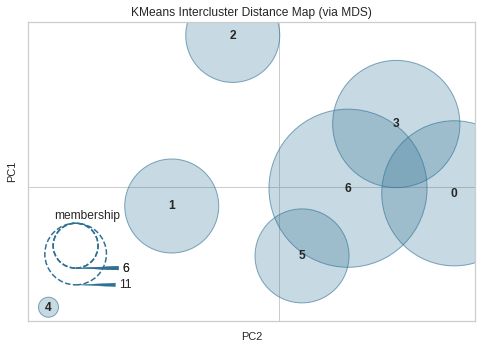

<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [461]:
from yellowbrick.cluster import InterclusterDistance

# Generate synthetic dataset with 12 random clusters
# X, y = make_blobs(n_samples=1000, n_features=12, centers=12, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
visualizer = InterclusterDistance(model)

visualizer.fit(df_COMPS_2D)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [462]:
for i in range (0,35):
    print(i,crystalnames[i],labels_7_2DPCA[i],crystalnames[i],labels_7_2DPCA[i+35])
#[(i,crystalnames[i],labels_7_2DPCA[i],crystalnames[i],labels_7_2DPCA[i+34]) for i in range (1,36)]
#print(crystalnames)
for i in range (0,35):
    print(i,crystalnames[i],gmix_7_2DPCA[i],crystalnames[i],gmix_7_2DPCA[i+35])
    
# KMEANS mism: Sr 4-1, Mo 0-2, Ti 0-6, Tc 2-6, Pd 0-6, GMIX V 3-4, Ti 3-4 Pd 3-4

0 Tl 5 Tl 5
1 Pb 5 Pb 5
2 Sn 1 Sn 1
3 Rb 0 Rb 0
4 In 1 In 1
5 Zr 1 Zr 1
6 Y 5 Y 5
7 Ta 4 Ta 4
8 Sr 3 Sr 3
9 Re 4 Re 4
10 Nb 1 Nb 1
11 Na 3 Na 3
12 K 0 K 0
13 Cd 1 Cd 1
14 Ag 1 Ag 1
15 Rh 4 Rh 4
16 Os 4 Os 4
17 Mo 1 Mo 4
18 Sc 1 Sc 1
19 Mg 2 Mg 2
20 V 6 V 6
21 Ti 1 Ti 6
22 Tc 4 Tc 6
23 Ru 4 Ru 4
24 Pt 4 Pt 4
25 Pd 1 Pd 6
26 Ir 4 Ir 4
27 Ge 1 Ge 1
28 Cr 6 Cr 6
29 Ca 3 Ca 3
30 Au 1 Au 1
31 Al 2 Al 2
32 Mn 6 Mn 6
33 Cu 6 Cu 6
34 Li 2 Li 2
0 Tl 3 Tl 3
1 Pb 3 Pb 3
2 Sn 3 Sn 3
3 Rb 2 Rb 2
4 In 3 In 3
5 Zr 3 Zr 3
6 Y 3 Y 3
7 Ta 0 Ta 0
8 Sr 5 Sr 5
9 Re 0 Re 0
10 Nb 3 Nb 3
11 Na 5 Na 5
12 K 2 K 2
13 Cd 3 Cd 3
14 Ag 3 Ag 3
15 Rh 0 Rh 0
16 Os 0 Os 0
17 Mo 3 Mo 3
18 Sc 3 Sc 3
19 Mg 1 Mg 1
20 V 3 V 4
21 Ti 3 Ti 4
22 Tc 0 Tc 0
23 Ru 0 Ru 0
24 Pt 0 Pt 0
25 Pd 3 Pd 4
26 Ir 0 Ir 0
27 Ge 3 Ge 3
28 Cr 4 Cr 4
29 Ca 5 Ca 5
30 Au 3 Au 3
31 Al 6 Al 6
32 Mn 4 Mn 4
33 Cu 4 Cu 4
34 Li 6 Li 6


marker_explicit=[]

for pp in range (1,46):
    if pp==7 or pp==26 or pp==38 or pp==14 or pp==28 or pp==18 or pp==24:
        continue
        
    if pp==6 or pp==32 or pp==12:
        continue
        
    # crystalnames.append(crystal(pp))
    marker.append('OI')
    marker_explicit.append('circle')
    
for pp in range (1,46):
    if pp==7 or pp==26 or pp==38 or pp==14 or pp==28 or pp==18 or pp==24:
        continue
        
    if pp==6 or pp==32 or pp==12:
        continue
        
    # crystalnames.append(crystal(pp))
    marker.append('TI')
    marker_explicit.append('star-triangle-down')


In [463]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

features = X_mdf.keys() 

X = X_mdf_std

pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# data = StandardScaler().fit_transform(components)
data = scaler.fit_transform(components)
print(crystalnames)
fig = px.scatter(data, x=0, y=1, color=labels_7_2DPCA, color_continuous_scale='Turbo',opacity=0.4,text=crystalnames,width=1000, height=800, symbol=marker)
fig.update_traces(marker=dict(size=15,showscale=False))
fig.update_traces(textfont_size=15)
for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        line=dict(width=0.7),
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1],
        opacity=0.6
    )
    # angle=math.degrees(math.atan2(loadings[i, 1]-0, loadings[i, 0]-0))+45
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        font=dict(size=17),
        # bgcolor='grey'
        # textangle=angle
    )
    
fig.add_vline(x=0, line_width=0.7, line_dash="dash", line_color="black")
fig.add_hline(y=0, line_width=0.7, line_dash="dash", line_color="black")

axis_template_x=dict(
    linecolor='black',
    linewidth=1.5,
    title="PC1",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)

axis_template_y=dict(
    linecolor='black',
    linewidth=1.5,
    title="PC2",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.90
))
fig.update_layout(coloraxis_showscale=False)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})

fig.show()
print(loadings,loadings.shape)
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/LoadingsPlot.html')

['Tl', 'Pb', 'Sn', 'Rb', 'In', 'Zr', 'Y', 'Ta', 'Sr', 'Re', 'Nb', 'Na', 'K', 'Cd', 'Ag', 'Rh', 'Os', 'Mo', 'Sc', 'Mg', 'V', 'Ti', 'Tc', 'Ru', 'Pt', 'Pd', 'Ir', 'Ge', 'Cr', 'Ca', 'Au', 'Al', 'Mn', 'Cu', 'Li', 'Tl', 'Pb', 'Sn', 'Rb', 'In', 'Zr', 'Y', 'Ta', 'Sr', 'Re', 'Nb', 'Na', 'K', 'Cd', 'Ag', 'Rh', 'Os', 'Mo', 'Sc', 'Mg', 'V', 'Ti', 'Tc', 'Ru', 'Pt', 'Pd', 'Ir', 'Ge', 'Cr', 'Ca', 'Au', 'Al', 'Mn', 'Cu', 'Li']


[[-0.38954777 -0.75689101]
 [ 0.89865654 -0.33849102]
 [ 0.93551262 -0.24255739]
 [-0.38173249 -0.73956008]
 [ 0.83934317 -0.04291547]
 [-0.32982049 -0.87238691]
 [ 0.90317133 -0.28350437]
 [ 0.82630058 -0.166187  ]
 [-0.48028575 -0.21693456]
 [-0.76943941 -0.25162075]
 [ 0.65957728 -0.47041832]
 [-0.74578772 -0.24050504]
 [ 0.9566195  -0.21248771]
 [ 0.31263709  0.70676867]
 [ 0.93306922 -0.29113557]
 [-0.49696333 -0.598265  ]
 [ 0.15983153 -0.10859975]
 [-0.47551097  0.51277773]
 [ 0.02523013 -0.05040454]
 [-0.43966428  0.50113268]
 [-0.07597617  0.33633766]
 [-0.09553947 -0.0846728 ]
 [ 0.11058064  0.25478303]
 [-0.0646505  -0.11050927]
 [-0.50484416 -0.60774305]
 [ 0.40600955  0.67768582]
 [ 0.3794057  -0.84212221]
 [ 0.82651557  0.233903  ]
 [ 0.86710784 -0.42211456]
 [ 0.92728747  0.25755888]
 [ 0.94488841 -0.29182307]
 [-0.80801097 -0.16130604]
 [-0.31828728  0.05979702]
 [-0.39115957 -0.42468659]
 [-0.04034679 -0.49622305]] (35, 2)


'/home/massad/Documents/Linux_PHD/SUPERCELLS/LoadingsPlot.html'

In [464]:
from bokeh.models import (
    ColumnDataSource,
    LinearColorMapper,
    LogColorMapper,
    ColorBar,
    BasicTicker,
)
from bokeh.plotting import figure, output_file
from bokeh.io import show as show_
from bokeh.sampledata.periodic_table import elements
from bokeh.transform import dodge
from csv import reader
from matplotlib.colors import Normalize, LogNorm, to_hex
from matplotlib.cm import (
    plasma,
    inferno,
    magma,
    viridis,
    cividis,
    turbo,
    ScalarMappable,
)
from pandas import options
from typing import List
import warnings
def ptable_plotter(
    filename: str,
    show: bool = True,
    output_filename: str = None,
    width: int = 1050,
    cmap: str = "turbo",
    alpha: float = 0.65,
    extended: bool = True,
    periods_remove: List[int] = None,
    groups_remove: List[int] = None,
    log_scale: bool = False,
    cbar_height: float = None,
    cbar_standoff: int = 12,
    cbar_fontsize: int = 14,
    blank_color: str = "#c4c4c4",
    under_value: float = None,
    under_color: str = "#140F0E",
    over_value: float = None,
    over_color: str = "#140F0E",
    special_elements: List[str] = None,
    special_color: str = "#6F3023",
) -> figure:

    """
    Plot a heatmap over the periodic table of elements.

    Parameters
    ----------
    filename : str
        Path to the .csv file containing the data to be plotted.
    show : str
        If True, the plot will be shown.
    output_filename : str
        If not None, the plot will be saved to the specified (.html) file.
    width : float
        Width of the plot.
    cmap : str
        plasma, inferno, viridis, magma, cividis, turbo
    alpha : float
        Alpha value (transparency).
    extended : bool
        If True, the lanthanoids and actinoids will be shown.
    periods_remove : List[int]
        Period numbers to be removed from the plot.
    groups_remove : List[int]
        Group numbers to be removed from the plot.
    log_scale : bool
        If True, the colorbar will be logarithmic.
    cbar_height : int
        Height of the colorbar.
    cbar_standoff : int
        Distance between the colorbar and the plot.
    cbar_fontsize : int
        Fontsize of the colorbar label.
    blank_color : str
        Hexadecimal color of the elements without data.
    under_value : float
        Values <= under_value will be colored with under_color.
    under_color : str
        Hexadecimal color to be used for the lower bound color.
    over_value : float
        Values >= over_value will be colored with over_color.
    under_color : str
        Hexadecial color to be used for the upper bound color.
    special_elements: List[str]
        List of elements to be colored with special_color.
    special_color: str
        Hexadecimal color to be used for the special elements.

    Returns
    -------
    figure
        Bokeh figure object.
    """

    options.mode.chained_assignment = None

    # Assign color palette based on input argument
    if cmap == "plasma":
        cmap = plasma
        bokeh_palette = "Plasma256"
    elif cmap == "inferno":
        cmap = inferno
        bokeh_palette = "Inferno256"
    elif cmap == "magma":
        cmap = magma
        bokeh_palette = "Magma256"
    elif cmap == "viridis":
        cmap = viridis
        bokeh_palette = "Viridis256"
    elif cmap == "cividis":
        cmap = cividis
        bokeh_palette = "Cividis256"
    elif cmap == "turbo":
        cmap = turbo
        bokeh_palette = "Turbo256"
    else:
        ValueError("Invalid color map.")

    # Define number of and groups
    period_label = ["1", "2", "3", "4", "5", "6", "7"]
    group_range = [str(x) for x in range(1, 19)]

    # Remove any groups or periods
    if groups_remove:
        for gr in groups_remove:
            gr = gr.strip()
            group_range.remove(str(gr))
    if periods_remove:
        for pr in periods_remove:
            pr = pr.strip()
            period_label.remove(str(pr))

    # Read in data from CSV file
    data_elements = []
    data_list = []
    for row in reader(open(filename)):
        data_elements.append(row[0])
        data_list.append(row[1])
    data = [float(i) for i in data_list]

    if len(data) != len(data_elements):
        raise ValueError("Unequal number of atomic elements and data points")

    period_label.append("blank")
    period_label.append("La")
    period_label.append("Ac")

    if extended:
        count = 0
        for i in range(56, 70):
            elements.period[i] = "La"
            elements.group[i] = str(count + 4)
            count += 1

        count = 0
        for i in range(88, 102):
            elements.period[i] = "Ac"
            elements.group[i] = str(count + 4)
            count += 1

    # Define matplotlib and bokeh color map
    if log_scale:
        for datum in data:
            if datum < 0:
                raise ValueError(
                    f"Entry for element {datum} is negative but log-scale is selected"
                )
        color_mapper = LogColorMapper(
            palette=bokeh_palette, low=min(data), high=max(data)
        )
        norm = LogNorm(vmin=min(data), vmax=max(data))
    else:
        color_mapper = LinearColorMapper(
            palette=bokeh_palette, low=min(data), high=6
        )
        norm = Normalize(vmin=min(data), vmax=6)
    color_scale = ScalarMappable(norm=norm, cmap=cmap).to_rgba(data, alpha=None)

    # Set blank color
    color_list = [blank_color] * len(elements)

    # Compare elements in dataset with elements in periodic table
    for i, data_element in enumerate(data_elements):
        element_entry = elements.symbol[
            elements.symbol.str.lower() == data_element.lower()
        ]
        if element_entry.empty == False:
            element_index = element_entry.index[0]
        else:
            warnings.warn("Invalid chemical symbol: " + data_element)
        if color_list[element_index] != blank_color:
            warnings.warn("Multiple entries for element " + data_element)
        elif under_value is not None and data[i] <= under_value:
            color_list[element_index] = under_color
        elif over_value is not None and data[i] >= over_value:
            color_list[element_index] = over_color
        else:
            color_list[element_index] = to_hex(color_scale[i])

    if special_elements:
        for k, v in elements["symbol"].iteritems():
            if v in special_elements:
                color_list[k] = special_color

    # Define figure properties for visualizing data
    source = ColumnDataSource(
        data=dict(
            group=[str(x) for x in elements["group"]],
            period=[str(y) for y in elements["period"]],
            sym=elements["symbol"],
            atomic_number=elements["atomic number"],
            type_color=color_list,
        )
    )

    # Plot the periodic table
    p = figure(x_range=group_range, y_range=list(reversed(period_label)), tools="save")
    p.plot_width = width
    p.outline_line_color = None
    p.background_fill_color = None
    p.border_fill_color = None
    p.toolbar_location = "above"
    p.rect("group", "period", 0.9, 0.9, source=source, alpha=alpha, color="type_color")
    p.axis.visible = False
    text_props = {
        "source": source,
        "angle": 0,
        "color": "black",
        "text_align": "left",
        "text_baseline": "middle",
    }
    x = dodge("group", -0.4, range=p.x_range)
    y = dodge("period", 0.3, range=p.y_range)
    p.text(
        x=x,
        y="period",
        text="sym",
        text_font_style="bold",
        text_font_size="16pt",
        **text_props,
    )
    p.text(x=x, y=y, text="atomic_number", text_font_size="11pt", **text_props)

    color_bar = ColorBar(
        color_mapper=color_mapper,
        ticker=BasicTicker(desired_num_ticks=10),
        border_line_color=None,
        label_standoff=cbar_standoff,
        location=(0, 0),
        orientation="vertical",
        scale_alpha=alpha,
        major_label_text_font_size=f"{cbar_fontsize}pt",
    )

    if cbar_height is not None:
        color_bar.height = cbar_height

    p.add_layout(color_bar, "right")
    p.grid.grid_line_color = None

    if output_filename:
        output_file(output_filename)

    if show:
        show_(p)

    return p

label_info_7_KM_OI = pd.DataFrame(labels_7_2DPCA[:35],columns=['label'],index=crystalnames[:35])
label_info_7_KM_TI = pd.DataFrame(labels_7_2DPCA[35:70],columns=['label'],index=crystalnames[35:70])

print(label_info_7_KM_OI)
label_info_7_KM_OI.to_csv('labels_7KM_OI.csv', index=True,header=False) 
print(label_info_7_KM_TI)
label_info_7_KM_TI.to_csv('labels_7KM_TI.csv', index=True,header=False) 


    label
Tl      5
Pb      5
Sn      1
Rb      0
In      1
Zr      1
Y       5
Ta      4
Sr      3
Re      4
Nb      1
Na      3
K       0
Cd      1
Ag      1
Rh      4
Os      4
Mo      1
Sc      1
Mg      2
V       6
Ti      1
Tc      4
Ru      4
Pt      4
Pd      1
Ir      4
Ge      1
Cr      6
Ca      3
Au      1
Al      2
Mn      6
Cu      6
Li      2
    label
Tl      5
Pb      5
Sn      1
Rb      0
In      1
Zr      1
Y       5
Ta      4
Sr      3
Re      4
Nb      1
Na      3
K       0
Cd      1
Ag      1
Rh      4
Os      4
Mo      4
Sc      1
Mg      2
V       6
Ti      6
Tc      6
Ru      4
Pt      4
Pd      6
Ir      4
Ge      1
Cr      6
Ca      3
Au      1
Al      2
Mn      6
Cu      6
Li      2


In [467]:
ptable_plotter("labels_7KM_OI.csv",output_filename='OI_tableplot',log_scale=False,show=True)

Figure(id='1764', ...)

In [468]:
ptable_plotter("labels_7KM_TI.csv",output_filename='TI_tableplot',log_scale=False,show=True)

Figure(id='1954', ...)

In [469]:
# s = np.linspace(-1, 1, num=41)
# print(s)
# np.append(loadings, s, axis=1)
# print(loadings.shape)
loading_matrix = pd.DataFrame(loadings,columns=['PC1', 'PC2'],index=features)
# loading_matrix.loc[len(loading_matrix)] = s
print(loading_matrix)
loading_matrix.to_csv('loading_matrix.csv', index=True) 


                                    PC1       PC2
Atomic Number                 -0.389548 -0.756891
Atomic Radius                  0.898657 -0.338491
Atomic Volume                  0.935513 -0.242557
atomic_weight                 -0.381732 -0.739560
dipole_polarizability          0.839343 -0.042915
period                        -0.329820 -0.872387
covalent_radius_pyykko_double  0.903171 -0.283504
c6_gb                          0.826301 -0.166187
dipole_polarizability_unc     -0.480286 -0.216935
heat_of_formation             -0.769439 -0.251621
ionic_radii                    0.659577 -0.470418
melting_point                 -0.745788 -0.240505
metallic_radius_c12            0.956620 -0.212488
specific_heat                  0.312637  0.706769
vdw_radius_mm3                 0.933069 -0.291136
VALENCE                       -0.496963 -0.598265
peak1_pos                      0.159832 -0.108600
peak1_height                  -0.475511  0.512778
peak1_width                    0.025230 -0.050405


In [470]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

features = X_mdf.keys() 

X = X_mdf_std

pca = PCA(n_components=4)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# data = StandardScaler().fit_transform(components)
data = scaler.fit_transform(components)

print(loadings[:,2:],loadings[:,2:].shape)

fig = px.scatter(data[:,2:], x=0, y=1, color=labels_7_2DPCA, color_continuous_scale='Turbo',opacity=0.4,text=crystalnames,width=1000, height=800,symbol=marker)
fig.update_traces(marker=dict(size=15))
fig.update_traces(textfont_size=15)
for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        line=dict(width=0.7),
        x0=0, y0=0,
        x1=loadings[i, 2],
        y1=loadings[i, 3],
        opacity=0.6
    )
    fig.add_annotation(
        x=loadings[i, 2],
        y=loadings[i, 3],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        font=dict(size=17)
        # bgcolor='grey'
    )
    
fig.add_vline(x=0, line_width=0.7, line_dash="dash", line_color="black")
fig.add_hline(y=0, line_width=0.7, line_dash="dash", line_color="black")

axis_template_x=dict(
    linecolor='black',
    linewidth=1.5,
    title="PC3",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)

axis_template_y=dict(
    linecolor='black',
    linewidth=1.5,
    title="PC4",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.90
))
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(coloraxis_showscale=False)
fig.show()
print(loadings,loadings.shape)
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/LoadingsPlot_1.html')

[[ 8.59591760e-02 -3.18094430e-01]
 [-1.23787673e-01  7.17699165e-03]
 [-1.62224024e-01 -7.75092983e-02]
 [ 9.24106439e-02 -3.32999150e-01]
 [-2.61958343e-01  6.32947924e-02]
 [-1.59610483e-02 -2.01508921e-01]
 [-7.64183615e-02 -6.21699207e-02]
 [-2.84641034e-01  5.82100879e-02]
 [-2.37640935e-01  5.22327970e-01]
 [-1.15177973e-01  1.30229820e-01]
 [-9.53559240e-02 -1.62708264e-01]
 [-1.51866688e-01  1.49697689e-01]
 [-1.05543551e-01 -5.68978710e-04]
 [ 6.58499396e-02  3.67758648e-02]
 [-9.09779846e-02 -1.65435652e-02]
 [-4.31314391e-03  3.02686462e-01]
 [ 7.18572668e-01  5.22366764e-01]
 [-5.11158259e-01 -6.77708002e-02]
 [ 6.80576116e-01  6.16737867e-01]
 [-4.78903686e-01 -2.03266447e-01]
 [ 7.55728705e-01 -3.28365415e-02]
 [-5.52489524e-01  6.88176865e-01]
 [ 5.67883317e-01  1.26912315e-01]
 [-5.58705259e-01  6.80262485e-01]
 [-1.18809422e-03  2.97705764e-01]
 [-1.03019037e-01  1.57650046e-01]
 [ 2.26325304e-01  3.62885262e-02]
 [ 2.18840157e-01  4.42496262e-02]
 [-1.19092673e-01 -4

[[-3.89547768e-01 -7.56891006e-01  8.59591760e-02 -3.18094430e-01]
 [ 8.98656536e-01 -3.38491016e-01 -1.23787673e-01  7.17699165e-03]
 [ 9.35512617e-01 -2.42557392e-01 -1.62224024e-01 -7.75092983e-02]
 [-3.81732492e-01 -7.39560082e-01  9.24106439e-02 -3.32999150e-01]
 [ 8.39343172e-01 -4.29154732e-02 -2.61958343e-01  6.32947924e-02]
 [-3.29820490e-01 -8.72386912e-01 -1.59610483e-02 -2.01508921e-01]
 [ 9.03171330e-01 -2.83504375e-01 -7.64183615e-02 -6.21699207e-02]
 [ 8.26300579e-01 -1.66186996e-01 -2.84641034e-01  5.82100879e-02]
 [-4.80285754e-01 -2.16934565e-01 -2.37640935e-01  5.22327970e-01]
 [-7.69439410e-01 -2.51620753e-01 -1.15177973e-01  1.30229820e-01]
 [ 6.59577281e-01 -4.70418324e-01 -9.53559240e-02 -1.62708264e-01]
 [-7.45787716e-01 -2.40505035e-01 -1.51866688e-01  1.49697689e-01]
 [ 9.56619505e-01 -2.12487706e-01 -1.05543551e-01 -5.68978710e-04]
 [ 3.12637089e-01  7.06768673e-01  6.58499396e-02  3.67758648e-02]
 [ 9.33069217e-01 -2.91135570e-01 -9.09779846e-02 -1.65435652e

'/home/massad/Documents/Linux_PHD/SUPERCELLS/LoadingsPlot_1.html'

In [472]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

features = X_mdf.keys() 

X = X_mdf_std

pca = PCA(n_components=4)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# data = StandardScaler().fit_transform(components)
data = scaler.fit_transform(components)

print(loadings[:,2:],loadings[:,2:].shape)

fig = px.scatter(data[:,2:], x=0, y=1, color=labels_7_2DPCA, color_continuous_scale='Turbo',opacity=0.4,text=crystalnames,width=700, height=500,symbol=marker)
fig.update_traces(marker=dict(size=15))
fig.update_traces(textfont_size=17)
for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        line=dict(width=0.7),
        x0=0, y0=0,
        x1=loadings[i, 2],
        y1=loadings[i, 3],
        opacity=0.6
    )
    fig.add_annotation(
        x=loadings[i, 2],
        y=loadings[i, 3],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        font=dict(size=17)
        # bgcolor='grey'
    )
    
fig.add_vline(x=0, line_width=0.7, line_dash="dash", line_color="black")
fig.add_hline(y=0, line_width=0.7, line_dash="dash", line_color="black")

axis_template_x=dict(
    linecolor='black',
    linewidth=1.5,
    title="",
    tickfont = dict(size=25),
    titlefont = dict(size=25)
    
)

axis_template_y=dict(
    linecolor='black',
    linewidth=1.5,
    title="",
    tickfont = dict(size=25),
    titlefont = dict(size=25)
    
)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.90

))
fig.update_layout(showlegend=False)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(coloraxis_showscale=False)
fig.show()
print(loadings,loadings.shape)
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/LoadingsPlot_1_zoom.html')

[[ 8.59591760e-02 -3.18094430e-01]
 [-1.23787673e-01  7.17699165e-03]
 [-1.62224024e-01 -7.75092983e-02]
 [ 9.24106439e-02 -3.32999150e-01]
 [-2.61958343e-01  6.32947924e-02]
 [-1.59610483e-02 -2.01508921e-01]
 [-7.64183615e-02 -6.21699207e-02]
 [-2.84641034e-01  5.82100879e-02]
 [-2.37640935e-01  5.22327970e-01]
 [-1.15177973e-01  1.30229820e-01]
 [-9.53559240e-02 -1.62708264e-01]
 [-1.51866688e-01  1.49697689e-01]
 [-1.05543551e-01 -5.68978710e-04]
 [ 6.58499396e-02  3.67758648e-02]
 [-9.09779846e-02 -1.65435652e-02]
 [-4.31314391e-03  3.02686462e-01]
 [ 7.18572668e-01  5.22366764e-01]
 [-5.11158259e-01 -6.77708002e-02]
 [ 6.80576116e-01  6.16737867e-01]
 [-4.78903686e-01 -2.03266447e-01]
 [ 7.55728705e-01 -3.28365415e-02]
 [-5.52489524e-01  6.88176865e-01]
 [ 5.67883317e-01  1.26912315e-01]
 [-5.58705259e-01  6.80262485e-01]
 [-1.18809422e-03  2.97705764e-01]
 [-1.03019037e-01  1.57650046e-01]
 [ 2.26325304e-01  3.62885262e-02]
 [ 2.18840157e-01  4.42496262e-02]
 [-1.19092673e-01 -4

[[-3.89547768e-01 -7.56891006e-01  8.59591760e-02 -3.18094430e-01]
 [ 8.98656536e-01 -3.38491016e-01 -1.23787673e-01  7.17699165e-03]
 [ 9.35512617e-01 -2.42557392e-01 -1.62224024e-01 -7.75092983e-02]
 [-3.81732492e-01 -7.39560082e-01  9.24106439e-02 -3.32999150e-01]
 [ 8.39343172e-01 -4.29154732e-02 -2.61958343e-01  6.32947924e-02]
 [-3.29820490e-01 -8.72386912e-01 -1.59610483e-02 -2.01508921e-01]
 [ 9.03171330e-01 -2.83504375e-01 -7.64183615e-02 -6.21699207e-02]
 [ 8.26300579e-01 -1.66186996e-01 -2.84641034e-01  5.82100879e-02]
 [-4.80285754e-01 -2.16934565e-01 -2.37640935e-01  5.22327970e-01]
 [-7.69439410e-01 -2.51620753e-01 -1.15177973e-01  1.30229820e-01]
 [ 6.59577281e-01 -4.70418324e-01 -9.53559240e-02 -1.62708264e-01]
 [-7.45787716e-01 -2.40505035e-01 -1.51866688e-01  1.49697689e-01]
 [ 9.56619505e-01 -2.12487706e-01 -1.05543551e-01 -5.68978710e-04]
 [ 3.12637089e-01  7.06768673e-01  6.58499396e-02  3.67758648e-02]
 [ 9.33069217e-01 -2.91135570e-01 -9.09779846e-02 -1.65435652e

'/home/massad/Documents/Linux_PHD/SUPERCELLS/LoadingsPlot_1_zoom.html'

### PROVA

In [350]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(-1, 1))

# features = X_mdf.keys() 

# X = X_mdf_std

# pca = PCA(n_components=2)
# components = pca.fit_transform(X)

# print(PC_COMPS_2D)
# print(components)

loadings = pca.components_.T* np.sqrt(pca.explained_variance_)
print(loadings.shape)
# loadings = loadings[:,:1].T
# data = StandardScaler().fit_transform(components)
data = scaler.fit_transform(components)
print(crystalnames)
fig = px.scatter(data, x=0, y=1, color=gmix_7_2DPCA, color_continuous_scale='Turbo',opacity=0.4,text=crystalnames,width=1000, height=800, symbol=marker)
fig.update_traces(marker=dict(size=15,showscale=False))
fig.update_traces(textfont_size=15)
for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        line=dict(width=0.7),
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1],
        opacity=0.6
    )
    # angle=math.degrees(math.atan2(loadings[i, 1]-0, loadings[i, 0]-0))+45
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        font=dict(size=17),
        # bgcolor='grey'
        # textangle=angle
    )
    
fig.add_vline(x=0, line_width=0.7, line_dash="dash", line_color="black")
fig.add_hline(y=0, line_width=0.7, line_dash="dash", line_color="black")

axis_template_x=dict(
    linecolor='black',
    linewidth=1.5,
    title="PC1",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)

axis_template_y=dict(
    linecolor='black',
    linewidth=1.5,
    title="PC2",
    tickfont = dict(size=23),
    titlefont = dict(size=23)
    
)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.90
))
fig.update_layout(coloraxis_showscale=False)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})

fig.show()
print(loadings,loadings.shape)
# plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/LoadingsPlot.html')

(70, 35)
['Tl', 'Pb', 'Sn', 'Rb', 'In', 'Zr', 'Y', 'Ta', 'Sr', 'Re', 'Nb', 'Na', 'K', 'Cd', 'Ag', 'Rh', 'Os', 'Mo', 'Sc', 'Mg', 'V', 'Ti', 'Tc', 'Ru', 'Pt', 'Pd', 'Ir', 'Ge', 'Cr', 'Ca', 'Au', 'Al', 'Mn', 'Cu', 'Li', 'Tl', 'Pb', 'Sn', 'Rb', 'In', 'Zr', 'Y', 'Ta', 'Sr', 'Re', 'Nb', 'Na', 'K', 'Cd', 'Ag', 'Rh', 'Os', 'Mo', 'Sc', 'Mg', 'V', 'Ti', 'Tc', 'Ru', 'Pt', 'Pd', 'Ir', 'Ge', 'Cr', 'Ca', 'Au', 'Al', 'Mn', 'Cu', 'Li']


[[-2.39331468e-01 -5.38391865e-01  5.91206993e-01 ... -7.44057729e-04
   8.05131744e-05  6.22973692e-17]
 [-2.35128463e-01 -7.07923514e-01 -5.45452450e-02 ... -3.49100808e-04
  -2.99125044e-05 -3.05274895e-17]
 [-1.03113001e-01 -1.15104322e-01  6.66213917e-01 ... -1.39459031e-03
  -9.47072641e-05  1.41415661e-17]
 ...
 [ 5.97784920e-01  4.63848012e-01 -3.19049675e-01 ... -2.38375665e-03
  -8.49495671e-04 -7.66352223e-17]
 [ 2.30060562e-01  7.42734804e-02  4.42572292e-01 ...  8.44824473e-04
  -1.49858557e-04  2.82339336e-18]
 [-5.41720442e-01  1.13364194e+00 -8.52283970e-02 ... -4.16836859e-04
   9.54015316e-04  3.02761138e-17]] (70, 35)


In [359]:
# KMEANS CLUSTERS
positions=np.where(labels_7_2DPCA==0)
# print(positions)
for pos in positions:
    clust_0_KM_PC1=np.asarray(components[:,0])[pos]
    clust_0_KM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(labels_7_2DPCA==1)
# print(positions)
for pos in positions:
    clust_1_KM_PC1=np.asarray(components[:,0])[pos]
    clust_1_KM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(labels_7_2DPCA==2)
# print(positions)
for pos in positions:
    clust_2_KM_PC1=np.asarray(components[:,0])[pos]
    clust_2_KM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(labels_7_2DPCA==3)
# print(positions)
for pos in positions:
    clust_3_KM_PC1=np.asarray(components[:,0])[pos]
    clust_3_KM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(labels_7_2DPCA==4)
# print(positions)
for pos in positions:
    clust_4_KM_PC1=np.asarray(components[:,0])[pos]
    clust_4_KM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(labels_7_2DPCA==5)
# print(positions)
for pos in positions:
    clust_5_KM_PC1=np.asarray(components[:,0])[pos]
    clust_5_KM_PC2=np.asarray(components[:,1])[pos]
    
positions=np.where(labels_7_2DPCA==6)
# print(positions)
for pos in positions:
    clust_6_KM_PC1=np.asarray(components[:,0])[pos]
    clust_6_KM_PC2=np.asarray(components[:,1])[pos]
    
#     ------------------------------------------------------------------------------

# GM CLUSTERS
positions=np.where(gmix_7_2DPCA==0)
# print(positions)
for pos in positions:
    clust_0_GM_PC1=np.asarray(components[:,0])[pos]
    clust_0_GM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(gmix_7_2DPCA==1)
# print(positions)
for pos in positions:
    clust_1_GM_PC1=np.asarray(components[:,0])[pos]
    clust_1_GM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(gmix_7_2DPCA==2)
# print(positions)
for pos in positions:
    clust_2_GM_PC1=np.asarray(components[:,0])[pos]
    clust_2_GM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(gmix_7_2DPCA==3)
# print(positions)
for pos in positions:
    clust_3_GM_PC1=np.asarray(components[:,0])[pos]
    clust_3_GM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(gmix_7_2DPCA==4)
# print(positions)
for pos in positions:
    clust_4_GM_PC1=np.asarray(components[:,0])[pos]
    clust_4_GM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(gmix_7_2DPCA==5)
# print(positions)
for pos in positions:
    clust_5_GM_PC1=np.asarray(components[:,0])[pos]
    clust_5_GM_PC2=np.asarray(components[:,1])[pos]

positions=np.where(gmix_7_2DPCA==6)
# print(positions)
for pos in positions:
    clust_6_GM_PC1=np.asarray(components[:,0])[pos]
    clust_6_GM_PC2=np.asarray(components[:,1])[pos]

    

trace1=go.Scatter(x=components[:35,0], y=components[:35,1],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="circle",showscale=True,color=labels_7_2DPCA,colorbar=dict(title=".",x=0.44),colorscale='Turbo'),name="OI")
trace2=go.Scatter(x=components[35:70,0], y=components[35:70,1],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="star-triangle-down",color=labels_7_2DPCA,colorscale='Turbo'),name="TI")

trace3=go.Scatter(showlegend=False,x=components[:35,0], y=components[:35,1],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="circle",showscale=True,color=gmix_7_2DPCA,colorbar=dict(title="."),colorscale='Turbo'),name="OI")
trace4=go.Scatter(showlegend=False,x=components[35:70,0], y=components[35:70,1],text=crystalnames,
                   mode="markers+text",marker=dict(opacity=0.7,size=11.5,symbol="star-triangle-down",color=gmix_7_2DPCA,colorscale='Turbo'),name="TI")


fig=make_subplots(rows=1,cols=2,horizontal_spacing = 0.16,subplot_titles=('K-Means(n=7)',  'Gaussian-Mixture(n=7)'))
fig.update_annotations(font_size=34)

#fig = go.Figure(data=[trace1, trace2])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 1, 2)

fig['layout'].update(xaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(xaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                ))

fig['layout'].update(yaxis1=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                                 ))
fig['layout'].update(yaxis2=dict(showline=True,linecolor='black',linewidth=2,tickfont = dict(size=34),titlefont = dict(size=34),
                               ))

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})#,'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y)
fig.update_traces(textposition='top center',textfont_size=28)
fig.update_traces(marker_showscale=False)
fig.update_layout(font={"size":34})
# fig.layout.coloraxis.colorbar.title = 'Lat(MH)/Lat(M)'
fig.update_layout(legend=dict(
    yanchor="top",
    y=-0.02,
    xanchor="right",
    x=0.5
))
axis_template_x=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_x_2=dict(
    linecolor='black',
    linewidth=2,
    title="PC1",
    tickfont = dict(size=34),
    titlefont = dict(size=34)
)
axis_template_y=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
axis_template_y_2=dict(
    linecolor='black',
    linewidth=2,
    tickfont = dict(size=34),
    titlefont = dict(size=34),
    title="PC2"
)
fig.update_layout(xaxis=axis_template_x,yaxis=axis_template_y,xaxis2=axis_template_x_2,yaxis2=axis_template_y_2)

fig.add_shape(type='path',
              path=confidence_ellipse(clust_0_KM_PC1, clust_0_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(98,83,119)',row=1,col=1) #rgb(98,83,119) GREY

fig.add_shape(type='path',
              path=confidence_ellipse(clust_1_KM_PC1, clust_1_KM_PC2),
              line={'dash': 'dot'},
              line_color='#3283FE',row=1,col=1) # #3283FE light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_2_KM_PC1, clust_2_KM_PC2),
              line={'dash': 'dot'},
              line_color='#19D3F3',row=1,col=1) # #19D3F3 very light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_3_KM_PC1, clust_3_KM_PC2),
              line={'dash': 'dot'},
              line_color='#16FF32',row=1,col=1) #very light green

fig.add_shape(type='path',
              path=confidence_ellipse(clust_4_KM_PC1, clust_4_KM_PC2),
              line={'dash': 'dot'},
              line_color='#EECA3B',row=1,col=1) #stupid yellow

fig.add_shape(type='path',
              path=confidence_ellipse(clust_5_KM_PC1, clust_5_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=1) #rgb(217,95,2) arancio scuro

fig.add_shape(type='path',
              path=confidence_ellipse(clust_6_KM_PC1, clust_6_KM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=1) # rgb(102,17,0) marrone

# ----------------------------------------------------------------------------------------

fig.add_shape(type='path',
              path=confidence_ellipse(clust_0_GM_PC1, clust_0_GM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(98,83,119)',row=1,col=2) #rgb(98,83,119) GREY

fig.add_shape(type='path',
              path=confidence_ellipse(clust_1_GM_PC1, clust_1_GM_PC2),
              line={'dash': 'dot'},
              line_color='#3283FE',row=1,col=2) #3283FE light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_2_GM_PC1, clust_2_GM_PC2),
              line={'dash': 'dot'},
              line_color='#19D3F3',row=1,col=2) #19D3F3 very light blue

fig.add_shape(type='path',
              path=confidence_ellipse(clust_3_GM_PC1, clust_3_GM_PC2),
              line={'dash': 'dot'},
              line_color='#16FF32',row=1,col=2) #very light green

fig.add_shape(type='path',
              path=confidence_ellipse(clust_4_GM_PC1, clust_4_GM_PC2),
              line={'dash': 'dot'},
              line_color='#EECA3B',row=1,col=2) #stupid yellow

fig.add_shape(type='path',
              path=confidence_ellipse(clust_5_GM_PC1, clust_5_GM_PC2),
              line={'dash': 'dot'},
              line_color='orange',row=1,col=2) # rgb(217,95,2) arancio scuro

fig.add_shape(type='path',
              path=confidence_ellipse(clust_6_GM_PC1, clust_6_GM_PC2),
              line={'dash': 'dot'},
              line_color='rgb(217,95,2)',row=1,col=2) # rgb(102,17,0) marrone

fig.show()
# print(confidence_ellipse(clust_6_KM_PC1, clust_6_KM_PC2))
plotly.offline.plot(fig, filename='/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl7_2DPC_VS_GM_cl7_2DPC_onPCA.html')

'/home/massad/Documents/Linux_PHD/SUPERCELLS/KM_cl7_2DPC_VS_GM_cl7_2DPC_onPCA.html'